In [80]:
import pandas as pd
import matplotlib.pyplot as plt

def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

df = ler_csv('dados/ibovespa.csv')

In [81]:
def df_tratamento_dados(df):
    df = df.rename(columns={'Data':'data','Último': 'value'})
    df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['value'] = df['value'].interpolate(method='linear')
    df.set_index('data', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    return df

<AxesSubplot:xlabel='data'>

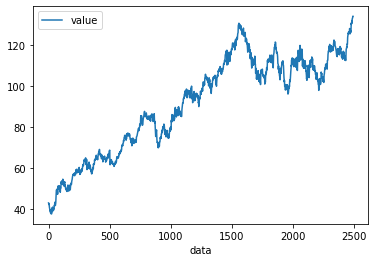

In [83]:
df_arima = df_tratamento_dados(df)
datas = pd.DataFrame(df_arima.index)
datas = datas.loc[(datas['data']>='2016-01-01')]
data1  = datas.loc[(datas['data']<='2020-01-01')]
data2 = datas.loc[datas['data'] >='2021-03-01']
datas = pd.concat([data1, data2])
datas.reset_index(drop=True, inplace=True)

treino = datas[datas['data'] <='2016-01-01']
percentual = len(treino)/len(datas)
entradas = 10
df_arima = df_arima.loc['2016-01-01':]
data1  = df_arima.loc[:'2020-01-01']
data2 = df_arima.loc['2021-03-01':]
df_arima = pd.concat([data1, data2])
df_arima.reset_index(drop=True, inplace=True)
df_arima.index.name = "data"
df_arima.plot()

In [49]:
df_arima

,value
data,
0,42.8664
1,42.6246
2,42.3828
3,42.1410
4,42.4190
...,...
2914,133.1430
2915,133.3380
2916,133.5330


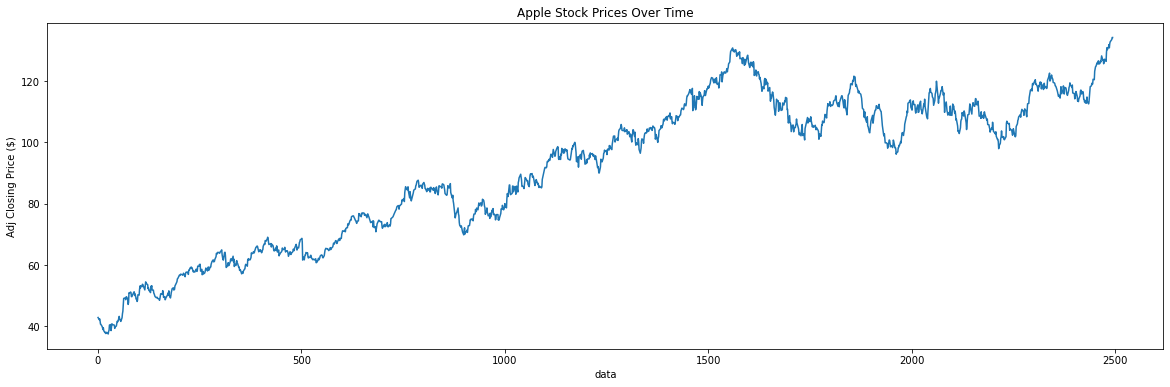

In [84]:
plt.figure(figsize=(20, 6))
plt.plot(df_arima["value"])
plt.xlabel("data")
plt.ylabel("Adj Closing Price ($)")
plt.title("Apple Stock Prices Over Time")
plt.show()

In [5]:
def split(df_arima, perc):
    train = df_arima[:int(len(df_arima)*perc)]
    test = df_arima[len(train):]
    print(len(train))
    print(len(test))
    return train, test

arima_train, arima_test = split(df_arima, 0.8)

4085
1022


In [85]:
# Função que separa por data

def split(df_arima, data):
    train = df_arima.loc[:data]
    test = df_arima[len(train):]
    print(len(df_arima))
    print(len(train))
    print(len(test))
    return train, test



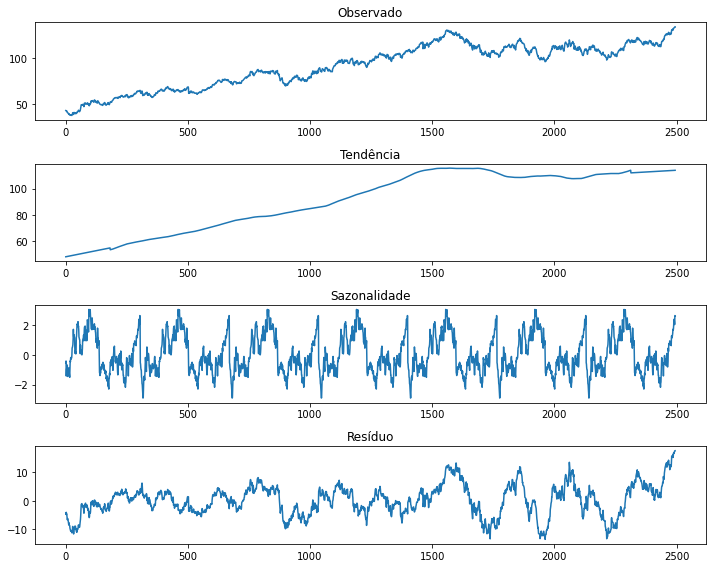

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(df_arima, model='additive',period=365,extrapolate_trend='freq')
# Plota o resultado da decomposição
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,8))

# Você pode alterar os rótulos aqui
ax1.set_title('Observado')
ax1.plot(result.observed)

ax2.set_title('Tendência')
ax2.plot(result.trend)

ax3.set_title('Sazonalidade')
ax3.plot(result.seasonal)

ax4.set_title('Resíduo')
ax4.plot(result.resid)

plt.tight_layout()
plt.show()

In [87]:
import itertools
def sarima_parameter_search(inicio,search_range, seasonal = [12]):
    """
    Get all of the parameter combinations for a SARIMA model.
    """
    p = q = d = range(inicio, search_range)
    trend = ['n','c','t','ct']
    pdq = list(itertools.product(p, d, q))
    pdq_combinations = [(x[0], x[1], x[2], x[3], x[4]) for x in list(itertools.product(p, d, q, seasonal, trend))]
    return pdq, pdq_combinations

### EXECUTE IN MAIN FUNCTION ###
order_combos, seasonal_order_combos = sarima_parameter_search(inicio=0, search_range = 2)

In [88]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
def seasonal_arima_model(time_series=None, order=None, seasonal_order=None, trend=None, steps=None, modo=None):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        if modo == "SARIMA":
            model = SARIMAX(time_series, 
                                       order=order, 
                                       seasonal_order=seasonal_order, 
                                       trend = trend,
                                       enforce_stationarity=False, 
                                       enforce_invertibility=False)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            # Calcule o MAE, MAPE e RMSE
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            mae = mean_absolute_error(arima_test, prediction)
            mape = mean_absolute_percentage_error(arima_test, prediction)
            return rmse,mae,mape, model_fit, prediction
        elif modo == "ARIMA":         
            model = ARIMA(time_series, order=order)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            mae = mean_absolute_error(arima_test, prediction)
            mape = mean_absolute_percentage_error(arima_test, prediction)
            
            return rmse,mae,mape, model_fit, prediction
    except:
        print("Could not fit with the designated model parameters")
        return None, None, None


def seasonal_arima_model_arima(time_series=None, order=None, steps=None):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        model = ARIMA(time_series, order=order)
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=steps)
        rmse = np.sqrt(mean_squared_error(arima_test, prediction))

        return rmse, model_fit, prediction
    except:
        print("Could not fit with the designated model parameters")
        return None, None, None

def grid_search(order_combos,seasonal_order_combos, df, steps, modo):
    lowest_rmse = 100000000000
    lowest_mae = 100000000000
    lowest_mape = 100000000000
    
    if modo == "ARIMA":
        for order_combo in order_combos:
            #Generate the ARIMA model
            rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                        order = order_combo, 
                                                        steps=steps,
                                                        modo=modo)
            print("order-- ", order_combo, ", lowest_rmse--",rmse)
            if (rmse < lowest_rmse):
                lowest_rmse = rmse
                best_model = model_fit
                best_order = order_combo
        melhor_conf = best_order
        return lowest_rmse,lowest_mae,lowest_mape,best_model,melhor_conf
                
    elif modo == "SARIMA":
        #Generate  model for each of hyperparameter combination in a loop
        for order_combo in order_combos:
            for seasonal_order_combo in seasonal_order_combos:
                #Convert the combination to list format
                seasonal_order_combo = list(seasonal_order_combo)
                #Generate the SARIMA model
                rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                            order = order_combo, 
                                                            seasonal_order = seasonal_order_combo[0:4],
                                                            trend = seasonal_order_combo[-1],
                                                            steps=steps,
                                                            modo=modo)
                print("order-- ", order_combo, ", seasonal order-- ", seasonal_order_combo, ", rmse--",rmse,", mae--",mae,", mape--",mape)
                if (rmse < lowest_rmse) or (mae < lowest_mae) or (mape < lowest_mape):
                    lowest_rmse = rmse
                    lowest_mae = mae
                    lowest_mape = mape
                    best_model = model_fit
                    best_order = order_combo
                    best_seasonal_order = seasonal_order_combo

                #print("Best model paramaters: order-- ", best_order, ", seasonal order-- ", best_seasonal_order, ", lowest_rmse--",lowest_rmse)
        melhor_conf = [best_order,tuple(best_seasonal_order[0:4]),best_seasonal_order[-1]]
        return lowest_rmse,lowest_mae,lowest_mape,best_model,melhor_conf

# base de treino curta e previsão longa

In [89]:
arima_train, arima_test = split(df_arima, '2021-05-01')

rmse,mae,mape,model, grid_search_melhor_conf, = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "ARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}\nrmse:{rmse}\nmae:{mae}\nmape:{mape}")




2495
2022
473
order--  (0, 0, 0) , lowest_rmse-- 28.208210253561354


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order--  (0, 0, 1) , lowest_rmse-- 28.1822504046576
order--  (0, 1, 0) , lowest_rmse-- 7.2610692034144355
order--  (0, 1, 1) , lowest_rmse-- 7.260217105265742
order--  (1, 0, 0) , lowest_rmse-- 8.592300722032455
order--  (1, 0, 1) , lowest_rmse-- 8.719103876943477
order--  (1, 1, 0) , lowest_rmse-- 7.2601348663391425
order--  (1, 1, 1) , lowest_rmse-- 7.259846607950489
A melhor configuração para essa série temporal é:(1, 1, 1)
rmse:7.259846607950489
mae:100000000000
mape:100000000000


In [90]:
rmse,mae,mape,model, grid_search_melhor_conf, = grid_search([(1, 1, 1)],seasonal_order_combos, arima_train, len(arima_test), "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}\nrmse:{rmse}\nmae:{mae}\nmape:{mape}")



order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.259847446121649 , mae-- 5.805758543150657 , mape-- 0.05096997916082756
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 9.765393176253326 , mae-- 8.27268985575313 , mape-- 0.07534894072413544


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 11.355373282183901 , mae-- 9.902371243007511 , mape-- 0.08954668932742586
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 7.3394246598076185 , mae-- 5.846987950465257 , mape-- 0.05162267551774115
order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 7.261494181632157 , mae-- 5.806565941835745 , mape-- 0.050966195555596804
order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 10.167232105816193 , mae-- 8.678034017768445 , mape-- 0.07892328991085631
order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 11.344572398691401 , mae-- 9.891589597011665 , mape-- 0.08945068420306974


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 7.338916469615445 , mae-- 5.846682624166523 , mape-- 0.05161329842995167
order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 56.277270155531205 , mae-- 50.007428371173326 , mape-- 0.4368707508615416
order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 69.39637925761961 , mae-- 60.33254510674502 , mape-- 0.5247243252135323
order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 43.76366676605212 , mae-- 39.87563339685096 , mape-- 0.3507345923968795
order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 32.78314145480448 , mae-- 30.32672532570541 , mape-- 0.269657405313457
order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 9.762129322188846 , mae-- 8.268728200894492 , mape-- 0.07532078844975662
order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 7.098216629791755 , mae-- 5.5971715261567425 , mape-- 0.04989533355009054
order--  (1, 1, 1) ,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 11.377419453994595 , mae-- 9.925365934417576 , mape-- 0.08974345033429457


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 7.330507142772829 , mae-- 5.839102619169236 , mape-- 0.051555826468320645
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 7.261492252022734 , mae-- 5.806564379291594 , mape-- 0.05096618801299121
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 10.167638369330767 , mae-- 8.678441772182474 , mape-- 0.07892683902999952
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 11.22599777716997 , mae-- 9.769270910642323 , mape-- 0.088390007775673
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 7.412952486099382 , mae-- 5.913040008364345 , mape-- 0.052109169744234074
order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 12.132366685304298 , mae-- 10.668010541410174 , mape-- 0.09607559697408363
order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 17.753515042844878 , mae-- 15.819556742907224 , mape-- 0.1399266766763335
order--  (1, 1

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 7.122480774189171e+132 , mae-- 5.827039160086235e+131 , mape-- 4.350333963864113e+129
order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 8.646826445193036e+132 , mae-- 7.072090286209622e+131 , mape-- 5.279850246686728e+129
A melhor configuração para essa série temporal é:[(1, 1, 1), (0, 1, 1, 12), 'c']
rmse:7.098216629791755
mae:5.5971715261567425
mape:0.04989533355009054


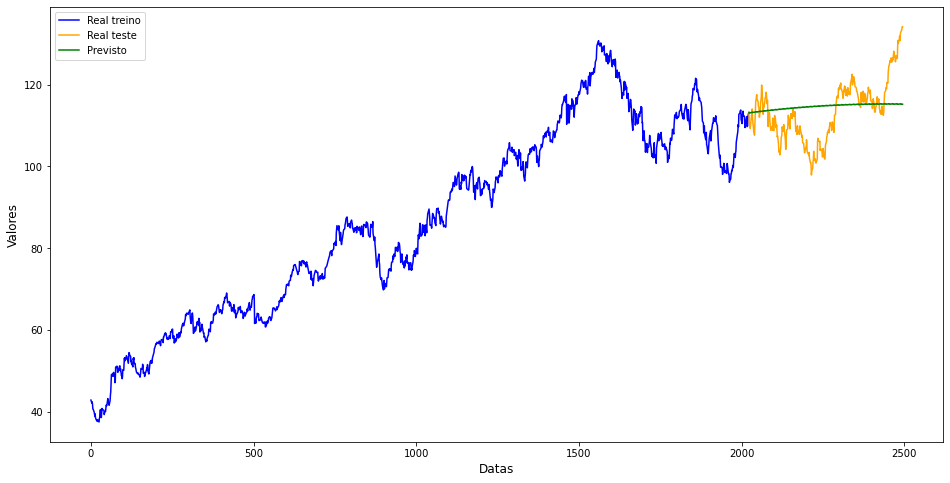

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = model.get_forecast(steps=len(arima_test))
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsto')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)


plt.legend()
plt.show()

In [69]:
datas['data'].iloc[:len(arima_train)]

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
2017   2021-07-10
2018   2021-07-11
2019   2021-07-12
2020   2021-07-13
2021   2021-07-14
Name: data, Length: 2022, dtype: datetime64[ns]

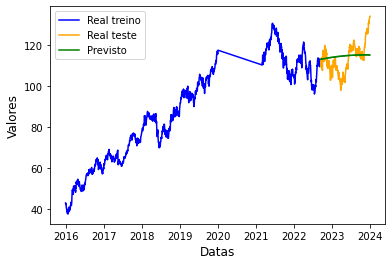

In [92]:
# Cria a figura e o eixo
fig, ax = plt.subplots()

# Plota os dados
ax.plot(datas['data'].iloc[:len(arima_train)],arima_train['value'],label='Real treino', color = 'blue')
ax.plot(datas['data'].iloc[len(arima_train):len(arima_train)+len(arima_test)],arima_test['value'],label='Real teste', color = 'orange')
ax.plot(datas['data'].iloc[len(arima_train):len(arima_train)+len(arima_test)],previsoes.predicted_mean,label='Previsto',color = 'green')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
# Formata as etiquetas do eixo x para mostrar apenas o ano
#ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Mostra a legenda
plt.legend()

# Mostra o gráfico
plt.show()

In [73]:
arima_train

,value
data,
0,42.8664
1,42.6246
2,42.3828
3,42.1410
4,42.4190
...,...
2017,126.5110
2018,127.0525
2019,127.5940


# base de treino curta e previsão curta

In [298]:
arima_train, arima_test = split(df_arima, '2017-01-01')
arima_test = arima_test.iloc[:int(len(arima_test) * 0.10)]
rmse,mae,mape,model, grid_search_melhor_conf, = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}\nrmse:{rmse}\nmae:{mae}\nmape:{mape}")

5107
2555
2552


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

A melhor configuração para essa série temporal é:[(1, 0, 0), (0, 1, 1, 12), 'ct']
rmse:3.475219320158745
mae:2.889531813804438
mape:0.04329078899294464


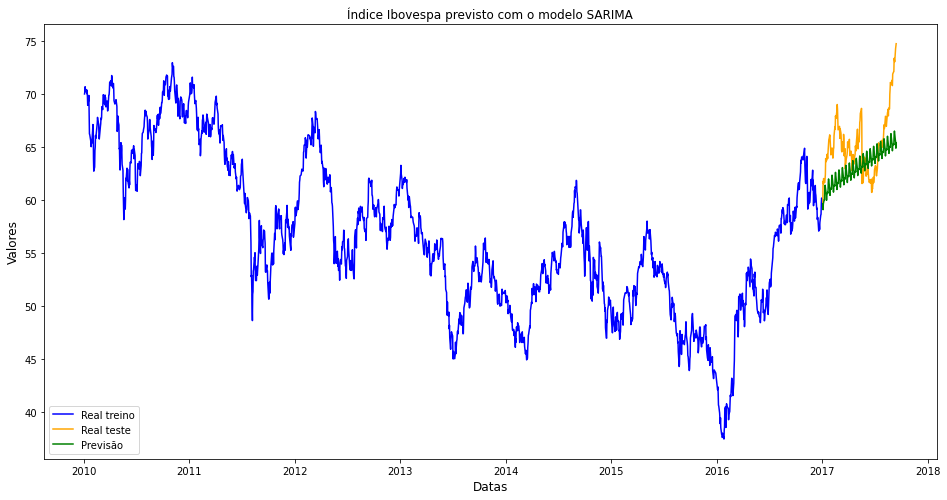

In [300]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = model.get_forecast(steps=len(arima_test))
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsão')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo SARIMA')

plt.legend()
plt.show()

# base de treino longa e previsão longa

In [301]:
arima_train, arima_test = split(df_arima, '2021-01-01')

rmse,mae,mape,model, grid_search_melhor_conf, = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}\nrmse:{rmse}\nmae:{mae}\nmape:{mape}")


5107
4016
1091


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

A melhor configuração para essa série temporal é:[(1, 0, 0), (1, 0, 1, 12), 'ct']
rmse:8.285881535044576
mae:6.2790101005370005
mape:0.054197497369128364


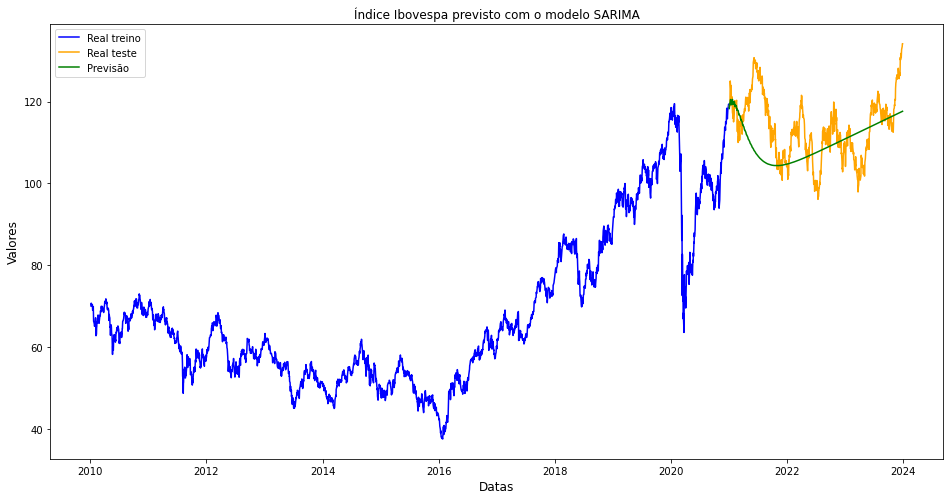

In [303]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = model.get_forecast(steps=len(arima_test))
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsão')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo SARIMA')

plt.legend()
plt.show()

# base de treino longa e previsão curta

In [304]:
arima_train, arima_test = split(df_arima, '2021-01-01')

arima_test = arima_test.iloc[:int(len(arima_test) * 0.20)]
rmse,mae,mape,model, grid_search_melhor_conf, = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}\nrmse:{rmse}\nmae:{mae}\nmape:{mape}")


5107
4016
1091


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

A melhor configuração para essa série temporal é:[(0, 0, 1), (1, 0, 0, 12), 't']
rmse:4.24216660984076
mae:3.3690070391336917
mape:0.02812998563546421


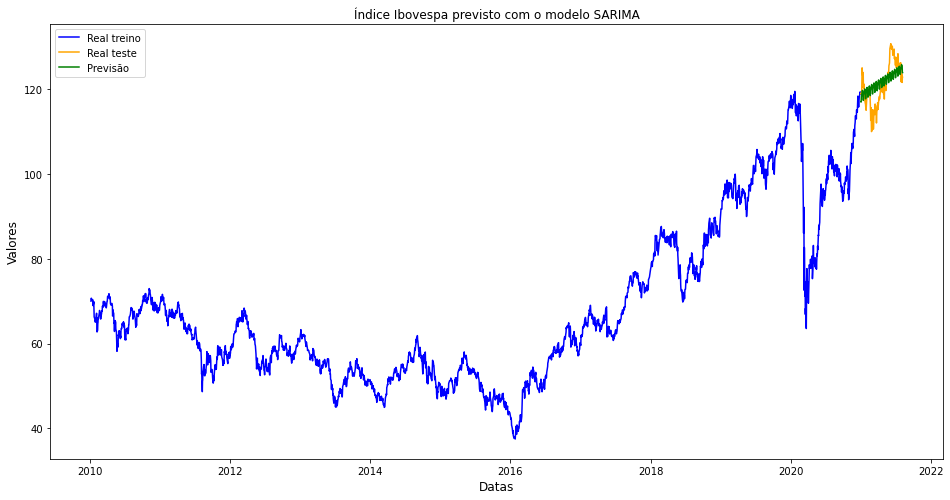

In [306]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = model.get_forecast(steps=len(arima_test))
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsão')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo SARIMA')

plt.legend()
plt.show()

# Prophet

In [178]:
from prophet import Prophet
df = ler_csv('dados/ibovespa.csv')
df_prophet = df_tratamento_dados(df)

df_prophet['ds'] = df_prophet.index.copy()
df_prophet.rename(columns={'value': 'y'}, inplace=True)
df_prophet.reset_index(inplace=True, drop=True)
df_prophet.dropna(inplace=True)

df_prophet
df_prophet['ds_copy'] = df_prophet['ds']
df_prophet.set_index('ds_copy', inplace=True)





# base de treino curta e previsão longa

In [179]:
df_prophet = df_prophet.loc['2016-01-01':]
data1  = df_prophet.loc[:'2020-01-01']
data2 = df_prophet.loc['2021-05-01':]
df_prophet = pd.concat([data1, data2])
#df_prophet.reset_index(drop=True, inplace=True)
#df_prophet.index.name = "data"

In [173]:
df_prophet

,y,ds
ds_copy,,
2016-01-01,42.8664,2016-01-01
2016-01-02,42.6246,2016-01-02
2016-01-03,42.3828,2016-01-03
2016-01-04,42.1410,2016-01-04
2016-01-05,42.4190,2016-01-05
...,...,...
2023-12-24,133.1430,2023-12-24
2023-12-25,133.3380,2023-12-25
2023-12-26,133.5330,2023-12-26


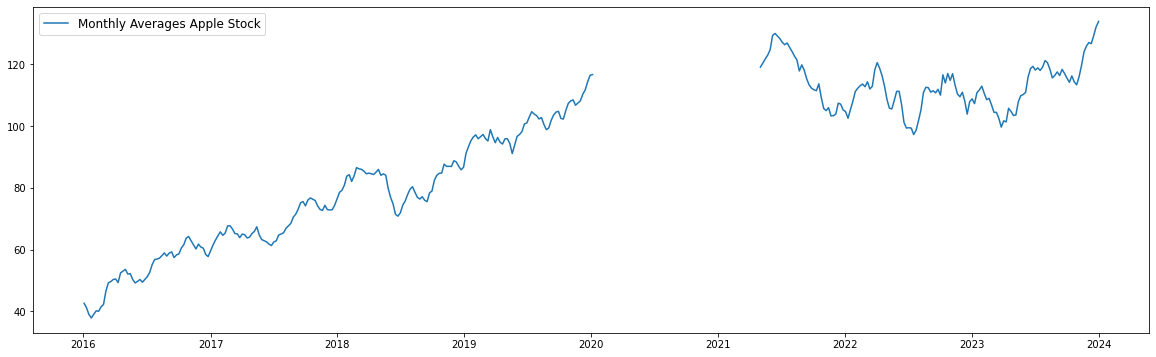

In [180]:
weakly_mean = df_prophet['y'].resample('W').mean()
df_prophet = weakly_mean.to_frame()
df_prophet['ds']=df_prophet.index
##Monthly Stock Price 
fig = plt.figure(figsize=(20,6))
plt.plot(df_prophet['y'],label='Monthly Averages Apple Stock')
plt.legend(prop={'size': 12})
plt.show()

In [187]:
prophet_train, prophet_test = split(df_prophet, '2020-01-01')

418
209
209


In [189]:
prophet_test

,y,ds
ds_copy,,
2020-01-05,116.621000,2020-01-05
2020-01-12,NaN,2020-01-12
2020-01-19,NaN,2020-01-19
2020-01-26,NaN,2020-01-26
2020-02-02,NaN,2020-02-02
...,...,...
2023-12-03,126.991286,2023-12-03
2023-12-10,126.634714,2023-12-10
2023-12-17,129.300571,2023-12-17


In [182]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,10,20],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1
    
    import holidays

# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())


import random
import numpy as np
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(prophet_train)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = prophet_test
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)
    
    
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

print(f"Melhores parâmetros: changepoint_prior_scale :{parameters.loc[0, 'Parameters']['changepoint_prior_scale']}\nholidays_prior_scale: {parameters.loc[0, 'Parameters']['holidays_prior_scale']}\nn_changepoints: {parameters.loc[0, 'Parameters']['n_changepoints']}\nchangepoint_range:{parameters.loc[0, 'Parameters']['changepoint_range']}\nseasonality_mode: {parameters.loc[0, 'Parameters']['seasonality_mode']}")

print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

predicao=train_forecast[['ds','yhat']]
Actual = prophet_test
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))


          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


23:07:34 - cmdstanpy - INFO - Chain [1] start processing
23:07:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.781167541255513
total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:36 - cmdstanpy - INFO - Chain [1] start processing
23:07:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.52354839196349
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:38 - cmdstanpy - INFO - Chain [1] start processing
23:07:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.785425479316482
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:40 - cmdstanpy - INFO - Chain [1] start processing
23:07:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.67271064194709
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:41 - cmdstanpy - INFO - Chain [1] start processing
23:07:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.7733500233998
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:43 - cmdstanpy - INFO - Chain [1] start processing
23:07:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.59980715635734
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:45 - cmdstanpy - INFO - Chain [1] start processing
23:07:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.7733500233998
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:47 - cmdstanpy - INFO - Chain [1] start processing
23:07:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.59980715635734
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:48 - cmdstanpy - INFO - Chain [1] start processing
23:07:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.775522863462715
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:50 - cmdstanpy - INFO - Chain [1] start processing
23:07:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.491112659406356
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:53 - cmdstanpy - INFO - Chain [1] start processing
23:07:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.794708203109671
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:56 - cmdstanpy - INFO - Chain [1] start processing
23:07:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.657400497365417
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:57 - cmdstanpy - INFO - Chain [1] start processing
23:07:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.771158657318361
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:59 - cmdstanpy - INFO - Chain [1] start processing
23:07:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.555706109455974
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:01 - cmdstanpy - INFO - Chain [1] start processing
23:08:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.771158657318361
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:03 - cmdstanpy - INFO - Chain [1] start processing
23:08:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.555706109455974
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:05 - cmdstanpy - INFO - Chain [1] start processing
23:08:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.76518089146391
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:07 - cmdstanpy - INFO - Chain [1] start processing
23:08:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.513967683489215
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:08 - cmdstanpy - INFO - Chain [1] start processing
23:08:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.782936758217879
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:10 - cmdstanpy - INFO - Chain [1] start processing
23:08:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.679122437477547
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:12 - cmdstanpy - INFO - Chain [1] start processing
23:08:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.771597244120722
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:14 - cmdstanpy - INFO - Chain [1] start processing
23:08:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.622522844585951
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:16 - cmdstanpy - INFO - Chain [1] start processing
23:08:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.771597244120722
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:18 - cmdstanpy - INFO - Chain [1] start processing
23:08:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.622522844585951
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:20 - cmdstanpy - INFO - Chain [1] start processing
23:08:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.7390541955798
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:21 - cmdstanpy - INFO - Chain [1] start processing
23:08:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.78307263231054
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:23 - cmdstanpy - INFO - Chain [1] start processing
23:08:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.781318904447874
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:24 - cmdstanpy - INFO - Chain [1] start processing
23:08:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.420614691007833
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:26 - cmdstanpy - INFO - Chain [1] start processing
23:08:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.711477125912618
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:27 - cmdstanpy - INFO - Chain [1] start processing
23:08:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.116474153336583
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:29 - cmdstanpy - INFO - Chain [1] start processing
23:08:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.7023425327171
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:30 - cmdstanpy - INFO - Chain [1] start processing
23:08:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.25861955810916
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:32 - cmdstanpy - INFO - Chain [1] start processing
23:08:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.73923105566322
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:33 - cmdstanpy - INFO - Chain [1] start processing
23:08:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.774414931512922
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:35 - cmdstanpy - INFO - Chain [1] start processing
23:08:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.713275473038376
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:37 - cmdstanpy - INFO - Chain [1] start processing
23:08:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.42221381320973
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:39 - cmdstanpy - INFO - Chain [1] start processing
23:08:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.705509351002801
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:41 - cmdstanpy - INFO - Chain [1] start processing
23:08:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.653453958829182
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:42 - cmdstanpy - INFO - Chain [1] start processing
23:08:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.70118684704037
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:44 - cmdstanpy - INFO - Chain [1] start processing
23:08:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.265561506694379
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:45 - cmdstanpy - INFO - Chain [1] start processing
23:08:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.746132019484174
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:46 - cmdstanpy - INFO - Chain [1] start processing
23:08:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.792697079733047
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:48 - cmdstanpy - INFO - Chain [1] start processing
23:08:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.747143361699386
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:49 - cmdstanpy - INFO - Chain [1] start processing
23:08:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.434928666605785
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:51 - cmdstanpy - INFO - Chain [1] start processing
23:08:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.709561181928743
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:52 - cmdstanpy - INFO - Chain [1] start processing
23:08:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.681813725476648
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:53 - cmdstanpy - INFO - Chain [1] start processing
23:08:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.694783088589041
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:55 - cmdstanpy - INFO - Chain [1] start processing
23:08:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.339543369525765
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:56 - cmdstanpy - INFO - Chain [1] start processing
23:08:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.661042855951749
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:58 - cmdstanpy - INFO - Chain [1] start processing
23:08:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.822987438673549
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:59 - cmdstanpy - INFO - Chain [1] start processing
23:08:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.659498170606874
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:01 - cmdstanpy - INFO - Chain [1] start processing
23:09:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.664617391849502
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:02 - cmdstanpy - INFO - Chain [1] start processing
23:09:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.651418779500778
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:04 - cmdstanpy - INFO - Chain [1] start processing
23:09:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.661593943009072
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:05 - cmdstanpy - INFO - Chain [1] start processing
23:09:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.648393404151472
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:07 - cmdstanpy - INFO - Chain [1] start processing
23:09:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.148901848880838
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:08 - cmdstanpy - INFO - Chain [1] start processing
23:09:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.668404397949107
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:10 - cmdstanpy - INFO - Chain [1] start processing
23:09:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.907401220839569
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:12 - cmdstanpy - INFO - Chain [1] start processing
23:09:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.65763599795194
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:14 - cmdstanpy - INFO - Chain [1] start processing
23:09:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.047273609155189
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:15 - cmdstanpy - INFO - Chain [1] start processing
23:09:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.664564435473986
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:17 - cmdstanpy - INFO - Chain [1] start processing
23:09:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.63584152611893
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:19 - cmdstanpy - INFO - Chain [1] start processing
23:09:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.66935418445036
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:20 - cmdstanpy - INFO - Chain [1] start processing
23:09:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.13756647026265
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:22 - cmdstanpy - INFO - Chain [1] start processing
23:09:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.663334716028197
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:23 - cmdstanpy - INFO - Chain [1] start processing
23:09:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.885992683606288
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:25 - cmdstanpy - INFO - Chain [1] start processing
23:09:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.657327951280537
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:28 - cmdstanpy - INFO - Chain [1] start processing
23:09:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.706832264536388
total: 

C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


 31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


23:09:31 - cmdstanpy - INFO - Chain [1] start processing
23:09:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.654735662977188
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:32 - cmdstanpy - INFO - Chain [1] start processing
23:09:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.54719078000286
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:34 - cmdstanpy - INFO - Chain [1] start processing
23:09:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.666304274947933
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:35 - cmdstanpy - INFO - Chain [1] start processing
23:09:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.116078462572984
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:37 - cmdstanpy - INFO - Chain [1] start processing
23:09:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.679315470806795
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:38 - cmdstanpy - INFO - Chain [1] start processing
23:09:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 27.697115976788766
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:40 - cmdstanpy - INFO - Chain [1] start processing
23:09:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.708727432021272
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 28.718537645561437
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:42 - cmdstanpy - INFO - Chain [1] start processing
23:09:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.653164281183937
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:44 - cmdstanpy - INFO - Chain [1] start processing
23:09:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 31.819425122469184
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:46 - cmdstanpy - INFO - Chain [1] start processing
23:09:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.653164281183937
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:47 - cmdstanpy - INFO - Chain [1] start processing
23:09:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 31.819425122469184
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:49 - cmdstanpy - INFO - Chain [1] start processing
23:09:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.662814392605144
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 35.848466577512944
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:52 - cmdstanpy - INFO - Chain [1] start processing
23:09:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.678699091683693
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:55 - cmdstanpy - INFO - Chain [1] start processing
23:09:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 29.954206259840767
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:57 - cmdstanpy - INFO - Chain [1] start processing
23:09:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.691652796647631
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:59 - cmdstanpy - INFO - Chain [1] start processing
23:09:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 30.412981075689846
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:00 - cmdstanpy - INFO - Chain [1] start processing
23:10:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.691652796647631
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:02 - cmdstanpy - INFO - Chain [1] start processing
23:10:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 30.412981075689846
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:04 - cmdstanpy - INFO - Chain [1] start processing
23:10:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.661877730178121
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:06 - cmdstanpy - INFO - Chain [1] start processing
23:10:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 32.980739945378566
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:08 - cmdstanpy - INFO - Chain [1] start processing
23:10:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.676916649576025
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:09 - cmdstanpy - INFO - Chain [1] start processing
23:10:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 33.61047238731737
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:10 - cmdstanpy - INFO - Chain [1] start processing
23:10:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.652406848035149
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:12 - cmdstanpy - INFO - Chain [1] start processing
23:10:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 32.58689396970012
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:14 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.652406848035149
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:15 - cmdstanpy - INFO - Chain [1] start processing
23:10:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 32.58689396970012
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:17 - cmdstanpy - INFO - Chain [1] start processing
23:10:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.551134450581884
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:18 - cmdstanpy - INFO - Chain [1] start processing
23:10:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 41.15112642495186
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:20 - cmdstanpy - INFO - Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.435711897789547
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.149072369115586
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:23 - cmdstanpy - INFO - Chain [1] start processing
23:10:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.280532211913224
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:24 - cmdstanpy - INFO - Chain [1] start processing
23:10:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.878718198992836
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:27 - cmdstanpy - INFO - Chain [1] start processing
23:10:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.495684185878618
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:28 - cmdstanpy - INFO - Chain [1] start processing
23:10:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 40.53418073325996
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:32 - cmdstanpy - INFO - Chain [1] start processing
23:10:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.214570698564792
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:33 - cmdstanpy - INFO - Chain [1] start processing
23:10:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42.01265453306456
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:36 - cmdstanpy - INFO - Chain [1] start processing
23:10:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.322110988483079
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:38 - cmdstanpy - INFO - Chain [1] start processing
23:10:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 40.62656606148574
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:40 - cmdstanpy - INFO - Chain [1] start processing
23:10:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.257310593022995
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:42 - cmdstanpy - INFO - Chain [1] start processing
23:10:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.03569333181202
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:44 - cmdstanpy - INFO - Chain [1] start processing
23:10:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.378321017294363
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:45 - cmdstanpy - INFO - Chain [1] start processing
23:10:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.811410640327125
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:47 - cmdstanpy - INFO - Chain [1] start processing
23:10:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.297170984284941
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:49 - cmdstanpy - INFO - Chain [1] start processing
23:10:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 40.81933926007159
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:51 - cmdstanpy - INFO - Chain [1] start processing
23:10:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.22873816957825
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:53 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.69783690559947
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:55 - cmdstanpy - INFO - Chain [1] start processing
23:10:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.280245520360689
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:56 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 36.071798761654854
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:58 - cmdstanpy - INFO - Chain [1] start processing
23:10:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.265816636513225
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:58 - cmdstanpy - INFO - Chain [1] start processing
23:10:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 40.02951318020157
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


23:10:59 - cmdstanpy - INFO - Chain [1] start processing
23:10:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.232216101606683
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


23:11:00 - cmdstanpy - INFO - Chain [1] start processing
23:11:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 38.61245090220548
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:11:01 - cmdstanpy - INFO - Chain [1] start processing
23:11:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.317820362764323
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


23:11:02 - cmdstanpy - INFO - Chain [1] start processing
23:11:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 36.215685665813
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:03 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.479504755108104
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:05 - cmdstanpy - INFO - Chain [1] start processing
23:11:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.68391053601811
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:09 - cmdstanpy - INFO - Chain [1] start processing
23:11:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.229185345594745
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:10 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.52581939467949
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:13 - cmdstanpy - INFO - Chain [1] start processing
23:11:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.42756462719516
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:15 - cmdstanpy - INFO - Chain [1] start processing
23:11:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.52411819640658
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:18 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.892177815752705
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:20 - cmdstanpy - INFO - Chain [1] start processing
23:11:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.526356503836375
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:24 - cmdstanpy - INFO - Chain [1] start processing
23:11:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.57639102640995
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:25 - cmdstanpy - INFO - Chain [1] start processing
23:11:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.283732813566225
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:29 - cmdstanpy - INFO - Chain [1] start processing
23:11:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.672557239405508
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:31 - cmdstanpy - INFO - Chain [1] start processing
23:11:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.01429408774379
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:35 - cmdstanpy - INFO - Chain [1] start processing
23:11:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.500189989038134
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:36 - cmdstanpy - INFO - Chain [1] start processing
23:11:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.705616890749326
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:37 - cmdstanpy - INFO - Chain [1] start processing
23:11:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.313839147213084
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


23:11:38 - cmdstanpy - INFO - Chain [1] start processing
23:11:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.27810275623758
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:39 - cmdstanpy - INFO - Chain [1] start processing
23:11:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.163612387149353
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


23:11:39 - cmdstanpy - INFO - Chain [1] start processing
23:11:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.44384858689618
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:42 - cmdstanpy - INFO - Chain [1] start processing
23:11:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.242107095706984
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:43 - cmdstanpy - INFO - Chain [1] start processing
23:11:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.857723267508405
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.986840693305297
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:48 - cmdstanpy - INFO - Chain [1] start processing
23:11:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 31.814373224726662
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:50 - cmdstanpy - INFO - Chain [1] start processing
23:11:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.945340278103167
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:51 - cmdstanpy - INFO - Chain [1] start processing
23:11:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 31.39166966829094
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:54 - cmdstanpy - INFO - Chain [1] start processing
23:11:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.954505617396567
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:57 - cmdstanpy - INFO - Chain [1] start processing
23:11:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 32.94050039727779
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:59 - cmdstanpy - INFO - Chain [1] start processing
23:11:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.954505617396567
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:01 - cmdstanpy - INFO - Chain [1] start processing
23:12:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 32.94050039727779
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:03 - cmdstanpy - INFO - Chain [1] start processing
23:12:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.027889947825782
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:04 - cmdstanpy - INFO - Chain [1] start processing
23:12:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 35.20994261298442
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:06 - cmdstanpy - INFO - Chain [1] start processing
23:12:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.911347292788053
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:08 - cmdstanpy - INFO - Chain [1] start processing
23:12:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 33.0595700030186
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:09 - cmdstanpy - INFO - Chain [1] start processing
23:12:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.931332757973106
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.69088369373415
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:13 - cmdstanpy - INFO - Chain [1] start processing
23:12:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.931332757973106
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:14 - cmdstanpy - INFO - Chain [1] start processing
23:12:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 37.69088369373415
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:16 - cmdstanpy - INFO - Chain [1] start processing
23:12:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.92025224497506
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 31.683157611101013
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:19 - cmdstanpy - INFO - Chain [1] start processing
23:12:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.88026142743537
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:21 - cmdstanpy - INFO - Chain [1] start processing
23:12:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 33.99097217983864
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:23 - cmdstanpy - INFO - Chain [1] start processing
23:12:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.937143714750492
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:24 - cmdstanpy - INFO - Chain [1] start processing
23:12:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 31.95918816780458
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:26 - cmdstanpy - INFO - Chain [1] start processing
23:12:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.937143714750492
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:27 - cmdstanpy - INFO - Chain [1] start processing
23:12:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 31.95918816780458
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:29 - cmdstanpy - INFO - Chain [1] start processing
23:12:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.557096467645504
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:31 - cmdstanpy - INFO - Chain [1] start processing
23:12:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 43.96854495317939
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:34 - cmdstanpy - INFO - Chain [1] start processing
23:12:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.487992450948108
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:36 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42.82578795062023
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:40 - cmdstanpy - INFO - Chain [1] start processing
23:12:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.298431335688761
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:42 - cmdstanpy - INFO - Chain [1] start processing
23:12:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42.51169614195572
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:48 - cmdstanpy - INFO - Chain [1] start processing
23:12:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.393434632435923
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:50 - cmdstanpy - INFO - Chain [1] start processing
23:12:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42.743760354642745
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:55 - cmdstanpy - INFO - Chain [1] start processing
23:12:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.516635319782043
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:57 - cmdstanpy - INFO - Chain [1] start processing
23:12:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 44.148581211836685
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.437054991645207
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:02 - cmdstanpy - INFO - Chain [1] start processing
23:13:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42.78879440545016
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.31692066815118
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:08 - cmdstanpy - INFO - Chain [1] start processing
23:13:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42.87089533541518
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:11 - cmdstanpy - INFO - Chain [1] start processing
23:13:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.291453413119713
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:13 - cmdstanpy - INFO - Chain [1] start processing
23:13:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 43.17130547130432
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:17 - cmdstanpy - INFO - Chain [1] start processing
23:13:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.531568331681044
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:18 - cmdstanpy - INFO - Chain [1] start processing
23:13:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 43.46356527933062
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:22 - cmdstanpy - INFO - Chain [1] start processing
23:13:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.649589095729258
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:24 - cmdstanpy - INFO - Chain [1] start processing
23:13:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42.738491025297556
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:27 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.389930008758475
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:29 - cmdstanpy - INFO - Chain [1] start processing
23:13:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42.64348382089861
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:32 - cmdstanpy - INFO - Chain [1] start processing
23:13:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.393674501619588
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:34 - cmdstanpy - INFO - Chain [1] start processing
23:13:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42.40594428453103
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:38 - cmdstanpy - INFO - Chain [1] start processing
23:13:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.517541546505102
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:40 - cmdstanpy - INFO - Chain [1] start processing
23:13:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.22508110307911
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:43 - cmdstanpy - INFO - Chain [1] start processing
23:13:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.567592296655455
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:45 - cmdstanpy - INFO - Chain [1] start processing
23:13:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.95423605245534
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.474448388775155
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:51 - cmdstanpy - INFO - Chain [1] start processing
23:13:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.57037886701783
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:54 - cmdstanpy - INFO - Chain [1] start processing
23:13:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.501718835542473
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.11768242462457
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:01 - cmdstanpy - INFO - Chain [1] start processing
23:14:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.597116263141617
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:03 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.14386114401824
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:06 - cmdstanpy - INFO - Chain [1] start processing
23:14:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.542300298877176
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:08 - cmdstanpy - INFO - Chain [1] start processing
23:14:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.690084324671226
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.588042958783328
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:13 - cmdstanpy - INFO - Chain [1] start processing
23:14:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.787005776288495
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:16 - cmdstanpy - INFO - Chain [1] start processing
23:14:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.509552501181641
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 38.67355910101043
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.528273301820455
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 38.20877227135713
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.480819231343938
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.787476575442334
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:23 - cmdstanpy - INFO - Chain [1] start processing
23:14:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.507211399049044
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 39.06506152611613
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:29 - cmdstanpy - INFO - Chain [1] start processing
23:14:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.481585471503246
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 38.277778276619635
total:  100.0
Melhores parâmetros: changepoint_prior_scale :0.01
holidays_prior_scale: 1
n_changepoints: 100
changepoint_range:0.8
seasonality_mode: additive
RMSE: 8.648393404151472
MAE: 6.750486719965064
MAPE: 0.05938325535551031
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_15268\2064965625.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


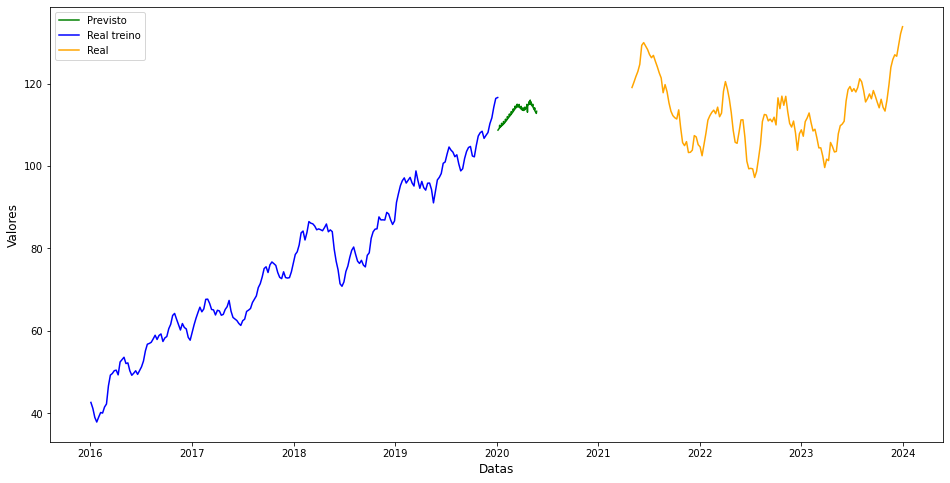

In [184]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Previsto')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()


In [185]:
best_prediction['ds']

0     2020-01-06
1     2020-01-07
2     2020-01-08
3     2020-01-09
4     2020-01-10
         ...    
135   2020-05-20
136   2020-05-21
137   2020-05-22
138   2020-05-23
139   2020-05-24
Name: ds, Length: 140, dtype: datetime64[ns]

# base de treino curta e previsão curta

In [324]:
prophet_train, prophet_test = split(df_prophet, '2017-01-01')
prophet_test = prophet_test.iloc[:int(len(prophet_test) * 0.10)]

5107
2555
2552


In [325]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,10,20],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1
    
    import holidays

# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())


import random
import numpy as np
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(prophet_train)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = prophet_test
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)
    
    
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()
print(f"Melhores parâmetros: changepoint_prior_scale :{parameters.loc[0, 'Parameters']['changepoint_prior_scale']}\nholidays_prior_scale: {parameters.loc[0, 'Parameters']['holidays_prior_scale']}\nn_changepoints: {parameters.loc[0, 'Parameters']['n_changepoints']}\nchangepoint_range:{parameters.loc[0, 'Parameters']['changepoint_range']}\nseasonality_mode: {parameters.loc[0, 'Parameters']['seasonality_mode']}")

print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

predicao=train_forecast[['ds','yhat']]
Actual = prophet_test
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))

          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


21:16:42 - cmdstanpy - INFO - Chain [1] start processing
21:16:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.08966066637392


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


21:16:45 - cmdstanpy - INFO - Chain [1] start processing
21:16:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.876126209080025
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:16:49 - cmdstanpy - INFO - Chain [1] start processing
21:16:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.01242808762919
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:16:52 - cmdstanpy - INFO - Chain [1] start processing
21:16:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.863076205266418
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:16:56 - cmdstanpy - INFO - Chain [1] start processing
21:16:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.05133935117164
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:16:59 - cmdstanpy - INFO - Chain [1] start processing
21:17:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.856811900738553
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:03 - cmdstanpy - INFO - Chain [1] start processing
21:17:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.031970730276623
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:04 - cmdstanpy - INFO - Chain [1] start processing
21:17:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.874067173297997
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:05 - cmdstanpy - INFO - Chain [1] start processing
21:17:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.056410087453767
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:07 - cmdstanpy - INFO - Chain [1] start processing
21:17:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.869696781597588
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:10 - cmdstanpy - INFO - Chain [1] start processing
21:17:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.001384857490965
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:14 - cmdstanpy - INFO - Chain [1] start processing
21:17:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.945298030830102
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:19 - cmdstanpy - INFO - Chain [1] start processing
21:17:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.037768393876874
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.90542910619545
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:23 - cmdstanpy - INFO - Chain [1] start processing
21:17:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.057283402147235
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:25 - cmdstanpy - INFO - Chain [1] start processing
21:17:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.823047377088349
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:29 - cmdstanpy - INFO - Chain [1] start processing
21:17:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.05420748876908
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:32 - cmdstanpy - INFO - Chain [1] start processing
21:17:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.893566692284772
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:33 - cmdstanpy - INFO - Chain [1] start processing
21:17:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 16.037230766053153
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.884513225562053
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:17:36 - cmdstanpy - INFO - Chain [1] start processing
21:17:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.04177096324225
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:37 - cmdstanpy - INFO - Chain [1] start processing
21:17:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.874046304445217
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:39 - cmdstanpy - INFO - Chain [1] start processing
21:17:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.041338005092932
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.864723603325222
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:46 - cmdstanpy - INFO - Chain [1] start processing
21:17:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.054911040813185
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:49 - cmdstanpy - INFO - Chain [1] start processing
21:17:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.904184057004844
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:50 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.154394967494367
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:52 - cmdstanpy - INFO - Chain [1] start processing
21:17:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 12.880317050308117
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:17:53 - cmdstanpy - INFO - Chain [1] start processing
21:17:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.079850353587572
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


21:17:54 - cmdstanpy - INFO - Chain [1] start processing
21:17:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 12.911194965575206
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


21:17:55 - cmdstanpy - INFO - Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.050894905561385
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:17:59 - cmdstanpy - INFO - Chain [1] start processing
21:18:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.877668708625233
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:02 - cmdstanpy - INFO - Chain [1] start processing
21:18:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.1026137448943
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:06 - cmdstanpy - INFO - Chain [1] start processing
21:18:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.870857307850505
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:11 - cmdstanpy - INFO - Chain [1] start processing
21:18:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.054856278203177
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:18 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.892763094068673
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:21 - cmdstanpy - INFO - Chain [1] start processing
21:18:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.05015592549821
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:23 - cmdstanpy - INFO - Chain [1] start processing
21:18:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.871290382498147
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:29 - cmdstanpy - INFO - Chain [1] start processing
21:18:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.046957728469337
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:33 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.900297578606311
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:37 - cmdstanpy - INFO - Chain [1] start processing
21:18:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.024655568982748
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:42 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.968951072162604
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:44 - cmdstanpy - INFO - Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.077146741140874
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:48 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.91934291483539
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:53 - cmdstanpy - INFO - Chain [1] start processing
21:18:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.086727284297181
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:18:56 - cmdstanpy - INFO - Chain [1] start processing
21:18:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.908023037240746
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:19:00 - cmdstanpy - INFO - Chain [1] start processing
21:19:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.03825384137565
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:19:03 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.902527073005029
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:19:05 - cmdstanpy - INFO - Chain [1] start processing
21:19:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.250138825360745
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.410821646660607
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:19:16 - cmdstanpy - INFO - Chain [1] start processing
21:19:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.84796348159144
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:19:21 - cmdstanpy - INFO - Chain [1] start processing
21:19:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.536232432432133
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:19:49 - cmdstanpy - INFO - Chain [1] start processing
21:19:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.449797774014755
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:19:52 - cmdstanpy - INFO - Chain [1] start processing
21:20:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.5989046309867625
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:20:44 - cmdstanpy - INFO - Chain [1] start processing
21:20:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.631676654653754
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:20:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.519534039360019
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.44202554241116
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:21:15 - cmdstanpy - INFO - Chain [1] start processing
21:21:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.413828826872553
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.535810097817018
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:21:50 - cmdstanpy - INFO - Chain [1] start processing
21:21:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 5.571264925889444
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:21:58 - cmdstanpy - INFO - Chain [1] start processing
21:21:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.637960593054709
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


21:22:00 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.591719735838105
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.612981601475928
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:22:43 - cmdstanpy - INFO - Chain [1] start processing
21:22:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 5.543912428714328
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


21:22:54 - cmdstanpy - INFO - Chain [1] start processing
21:22:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.599179026681261
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:22:56 - cmdstanpy - INFO - Chain [1] start processing
21:23:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.379245501892514
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:23:18 - cmdstanpy - INFO - Chain [1] start processing
21:23:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.458528055310863
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


21:23:20 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.496779262820295
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.518823891893787
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.586788692364188
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.24011497975063
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.469113712668735
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:24:29 - cmdstanpy - INFO - Chain [1] start processing
21:24:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.552190125732022
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:24:30 - cmdstanpy - INFO - Chain [1] start processing
21:24:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.482036485639867
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.597542417663178
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


21:24:37 - cmdstanpy - INFO - Chain [1] start processing
21:24:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.473529851777826
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.55085914624161
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.46172982908031
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.606988178674019
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:25:05 - cmdstanpy - INFO - Chain [1] start processing
21:25:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.460500787852324
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.592948549917441
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.41347423219681
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:25:25 - cmdstanpy - INFO - Chain [1] start processing
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.590164022576605
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


21:25:26 - cmdstanpy - INFO - Chain [1] start processing
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.468773396765535
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.61197128726021
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


21:25:36 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.470613226273429
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.596178232135816
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.464492867695704
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.543387244412473
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


21:26:23 - cmdstanpy - INFO - Chain [1] start processing
21:26:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.465239901027786
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.643510260057989
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.463099049168711
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.59237156049627
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:27:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.491016275782643
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


21:27:15 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.589759916967274
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.467705112895867
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:27:35 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.611430170755291
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.23449421346581
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:27:49 - cmdstanpy - INFO - Chain [1] start processing
21:27:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.617528221489197
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:27:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.238306317285746
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:28:16 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.599360845468063
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:28:21 - cmdstanpy - INFO - Chain [1] start processing
21:28:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.223709647189143
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.615278403742195
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:28:37 - cmdstanpy - INFO - Chain [1] start processing
21:28:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.287703024333473
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:28:50 - cmdstanpy - INFO - Chain [1] start processing
21:28:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.618052067525628
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:28:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.260736009175877
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:29:12 - cmdstanpy - INFO - Chain [1] start processing
21:29:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.63077206394411
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:29:15 - cmdstanpy - INFO - Chain [1] start processing
21:29:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.358474549035666
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.620384915995478
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:29:35 - cmdstanpy - INFO - Chain [1] start processing
21:29:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.232780554392747
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 12.62473261933577
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


21:29:48 - cmdstanpy - INFO - Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.250663567526605
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:30:05 - cmdstanpy - INFO - Chain [1] start processing
21:30:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.611183810358243
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.273787235694062
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:30:21 - cmdstanpy - INFO - Chain [1] start processing
21:30:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.622716001015295
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:30:23 - cmdstanpy - INFO - Chain [1] start processing
21:30:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.294169832123504
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.590093661415647
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:30:45 - cmdstanpy - INFO - Chain [1] start processing
21:31:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.262039664571235
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:31:05 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.611437130950415
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:31:12 - cmdstanpy - INFO - Chain [1] start processing
21:31:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.263011293374383
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 4.217961619104783
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:31:45 - cmdstanpy - INFO - Chain [1] start processing
21:31:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.932327167609986
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 4.367057525472642
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:32:15 - cmdstanpy - INFO - Chain [1] start processing
21:32:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 6.0325102079670625
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:32:27 - cmdstanpy - INFO - Chain [1] start processing
21:32:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 4.459738842909406
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:32:41 - cmdstanpy - INFO - Chain [1] start processing
21:33:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.977967249269312
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 4.590247644288446
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.9292916852233875
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:33:34 - cmdstanpy - INFO - Chain [1] start processing
21:33:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 4.465835307961953
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


21:33:40 - cmdstanpy - INFO - Chain [1] start processing
21:33:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 5.971236933666701
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:33:46 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 4.57638235766968
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


21:33:51 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 6.058011400809933
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:34:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 4.3362342614620415
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


21:34:02 - cmdstanpy - INFO - Chain [1] start processing
21:34:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 5.886508577893
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


21:34:11 - cmdstanpy - INFO - Chain [1] start processing
21:34:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 4.464900661113621
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:34:25 - cmdstanpy - INFO - Chain [1] start processing
21:34:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 5.924304848051869
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


21:34:35 - cmdstanpy - INFO - Chain [1] start processing
21:34:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 4.174171197062512
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 5.889079659359173
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:34:45 - cmdstanpy - INFO - Chain [1] start processing
21:34:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 4.541309160947611
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


21:34:49 - cmdstanpy - INFO - Chain [1] start processing
21:34:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 6.010778943275417
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:34:57 - cmdstanpy - INFO - Chain [1] start processing
21:35:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 4.464022489369309
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:35:07 - cmdstanpy - INFO - Chain [1] start processing
21:35:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 5.927643754835476
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


21:35:17 - cmdstanpy - INFO - Chain [1] start processing
21:35:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 4.488595688571926
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:35:22 - cmdstanpy - INFO - Chain [1] start processing
21:35:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 5.98061277998402
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


21:35:31 - cmdstanpy - INFO - Chain [1] start processing
21:35:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.443366756987613
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


21:35:34 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.455932040816519
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:35:36 - cmdstanpy - INFO - Chain [1] start processing
21:35:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.440595400321937
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:35:41 - cmdstanpy - INFO - Chain [1] start processing
21:35:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.457662636634447
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:35:46 - cmdstanpy - INFO - Chain [1] start processing
21:35:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.44340285314201
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


21:35:52 - cmdstanpy - INFO - Chain [1] start processing
21:36:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.445123674962918
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:36:04 - cmdstanpy - INFO - Chain [1] start processing
21:36:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.440921147342081
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


21:36:08 - cmdstanpy - INFO - Chain [1] start processing
21:36:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.473139130954635
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


21:36:12 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.43831592834696
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:36:14 - cmdstanpy - INFO - Chain [1] start processing
21:36:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.451720623882066
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:36:24 - cmdstanpy - INFO - Chain [1] start processing
21:36:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.435223093075265
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


21:36:27 - cmdstanpy - INFO - Chain [1] start processing
21:36:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.448152002234892
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:36:33 - cmdstanpy - INFO - Chain [1] start processing
21:36:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.449158570254014
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.438041018862425
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:36:48 - cmdstanpy - INFO - Chain [1] start processing
21:36:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.447857204866802
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


21:36:52 - cmdstanpy - INFO - Chain [1] start processing
21:36:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.443971713030594
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


21:36:57 - cmdstanpy - INFO - Chain [1] start processing
21:36:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.436608208853304
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:37:00 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.441776557534062
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:37:09 - cmdstanpy - INFO - Chain [1] start processing
21:37:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.448260771150672
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:37:17 - cmdstanpy - INFO - Chain [1] start processing
21:37:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.451804975309152
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:37:22 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.44446162713545
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:37:27 - cmdstanpy - INFO - Chain [1] start processing
21:37:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.452873807650244
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:37:33 - cmdstanpy - INFO - Chain [1] start processing
21:37:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.459232537006576
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.454591339316565
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.946783464873416
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:38:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.370232322923243
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:38:09 - cmdstanpy - INFO - Chain [1] start processing
21:38:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.010287713720567
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:38:12 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.424986854953696
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:38:23 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.004328067149729
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.401482885739641
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:38:45 - cmdstanpy - INFO - Chain [1] start processing
21:38:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.979332720738611
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:38:56 - cmdstanpy - INFO - Chain [1] start processing
21:39:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.435753856973891
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:39:06 - cmdstanpy - INFO - Chain [1] start processing
21:39:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.962694506962524
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:39:11 - cmdstanpy - INFO - Chain [1] start processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.423959057811825
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:39:23 - cmdstanpy - INFO - Chain [1] start processing
21:39:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.031135241897626
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


21:39:26 - cmdstanpy - INFO - Chain [1] start processing
21:39:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.368614220209825
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:39:32 - cmdstanpy - INFO - Chain [1] start processing
21:39:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.983791566271986
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:39:39 - cmdstanpy - INFO - Chain [1] start processing
21:39:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.432049140871495
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


21:39:52 - cmdstanpy - INFO - Chain [1] start processing
21:39:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 12.991485757415589
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


21:39:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.417482486394837
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.984688871361733
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:40:23 - cmdstanpy - INFO - Chain [1] start processing
21:40:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.41557166940947
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:40:36 - cmdstanpy - INFO - Chain [1] start processing
21:40:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.919045138062971
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:40:42 - cmdstanpy - INFO - Chain [1] start processing
21:40:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.401047676069181
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:40:48 - cmdstanpy - INFO - Chain [1] start processing
21:40:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.970388838174998
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.445624213859412
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:41:23 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.985490711077773
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.405904285228864
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.062360358639839
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:41:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 6.181412936641795
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:42:12 - cmdstanpy - INFO - Chain [1] start processing
21:42:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.1168137126697735
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:42:23 - cmdstanpy - INFO - Chain [1] start processing
21:42:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 6.146125700256934
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:42:40 - cmdstanpy - INFO - Chain [1] start processing
21:42:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.132124699113327
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:42:57 - cmdstanpy - INFO - Chain [1] start processing
21:43:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 6.2221758137506535
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


21:43:13 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.115350779517216
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:43:25 - cmdstanpy - INFO - Chain [1] start processing
21:43:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 6.215937417455891
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


21:43:45 - cmdstanpy - INFO - Chain [1] start processing
21:43:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 5.095206985583983
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


21:43:50 - cmdstanpy - INFO - Chain [1] start processing
21:43:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 6.08756347578288
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


21:43:57 - cmdstanpy - INFO - Chain [1] start processing
21:44:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.107373986337782
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:44:13 - cmdstanpy - INFO - Chain [1] start processing
21:44:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 6.482564250856095
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


21:44:22 - cmdstanpy - INFO - Chain [1] start processing
21:44:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.124709115466634
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:44:32 - cmdstanpy - INFO - Chain [1] start processing
21:44:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 6.145708196556424
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:44:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.103513859601166
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:45:01 - cmdstanpy - INFO - Chain [1] start processing
21:45:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 6.2429445925102245
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:45:16 - cmdstanpy - INFO - Chain [1] start processing
21:45:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.085231958990044
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:45:29 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 6.148324810819597
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.1180710790894235
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 6.182530951051543
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.119812795632073
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:46:34 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 6.5470813448359015
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:47:03 - cmdstanpy - INFO - Chain [1] start processing
21:47:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 5.106374818084223
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:47:44 - cmdstanpy - INFO - Chain [1] start processing
21:48:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 6.140923097175169
total:  100.0
Melhores parâmetros: changepoint_prior_scale :0.04
holidays_prior_scale: 20
n_changepoints: 50
changepoint_range:0.8
seasonality_mode: additive
RMSE: 4.174171197062512
MAE: 3.145230506311486
MAPE: 0.04763117491238234
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\877530458.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


6.140923097175169

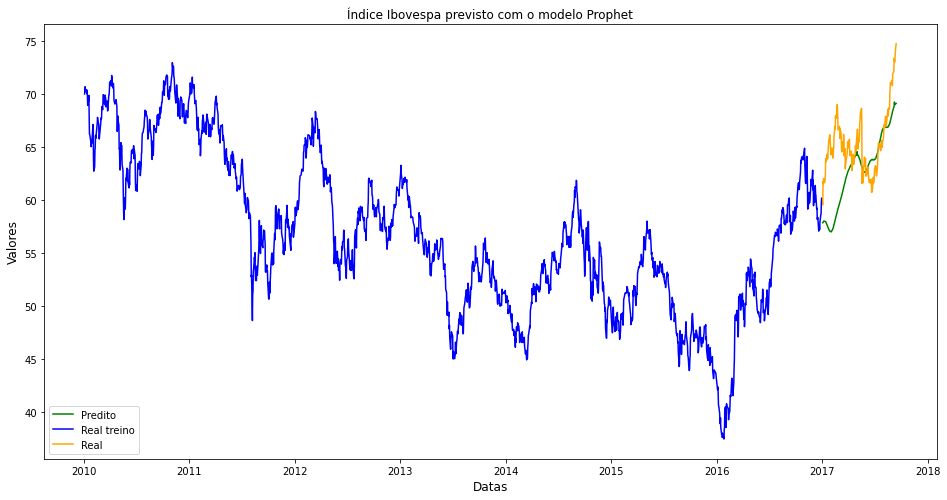

In [326]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Predito')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()


# base de treino longa e previsão curta

In [252]:
prophet_train, prophet_test = split(df_prophet, '2021-01-01')
prophet_test = prophet_test.iloc[:int(len(prophet_test) * 0.20)]

5107
4016
1091


In [253]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,10,20],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1
    
    import holidays

# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())


import random
import numpy as np
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(prophet_train)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = prophet_test
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)
    
    
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()
print(f"Melhores parâmetros: changepoint_prior_scale :{parameters.loc[0, 'Parameters']['changepoint_prior_scale']}\nholidays_prior_scale: {parameters.loc[0, 'Parameters']['holidays_prior_scale']}\nn_changepoints: {parameters.loc[0, 'Parameters']['n_changepoints']}\nchangepoint_range:{parameters.loc[0, 'Parameters']['changepoint_range']}\nseasonality_mode: {parameters.loc[0, 'Parameters']['seasonality_mode']}")

print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])


predicao=train_forecast[['ds','yhat']]
Actual = prophet_test
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
RMSE

          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.608530178371007
total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.221344939956843
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.559062494082603
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.181175837019246
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.541010344732566
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.19094982666573
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.536408957815128
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.301523444393409
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.630005989464625
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.233525696026256
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:25:43 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.62322443897769
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.197784632384185
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.57234548075451
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.331885365700924
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.54652127913442
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.265563372631831
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.58150258518367
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.268044781701791
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:26:15 - cmdstanpy - INFO - Chain [1] start processing
16:26:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.594698448230403
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.199594110697424
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:26:21 - cmdstanpy - INFO - Chain [1] start processing
16:26:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.576311984141908
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


16:26:23 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.377025375241905
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.518981819959118
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.356878572841625
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.177657091956457
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.09786719653113
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.112785112712174
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.07705806514366
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.12748270914206
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.056670291403261
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:27:15 - cmdstanpy - INFO - Chain [1] start processing
16:27:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.076899758697676
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:27:18 - cmdstanpy - INFO - Chain [1] start processing
16:27:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.117898912251546
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:27:28 - cmdstanpy - INFO - Chain [1] start processing
16:27:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.113304744836562
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:27:31 - cmdstanpy - INFO - Chain [1] start processing
16:27:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.131690630346181
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:27:41 - cmdstanpy - INFO - Chain [1] start processing
16:27:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.147332633148636
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:27:43 - cmdstanpy - INFO - Chain [1] start processing
16:27:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.169174174818494
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:27:53 - cmdstanpy - INFO - Chain [1] start processing
16:27:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.111301952022258
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:27:58 - cmdstanpy - INFO - Chain [1] start processing
16:28:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.169925573356014
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:28:10 - cmdstanpy - INFO - Chain [1] start processing
16:28:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.098991084092223
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:28:12 - cmdstanpy - INFO - Chain [1] start processing
16:28:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.077976971665493
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:28:21 - cmdstanpy - INFO - Chain [1] start processing
16:28:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.096863526335554
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:28:23 - cmdstanpy - INFO - Chain [1] start processing
16:28:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.106345903652151
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:28:33 - cmdstanpy - INFO - Chain [1] start processing
16:28:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.1198460807106
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:28:35 - cmdstanpy - INFO - Chain [1] start processing
16:28:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.140282571483962
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:28:42 - cmdstanpy - INFO - Chain [1] start processing
16:28:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.099903127540953
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


16:28:45 - cmdstanpy - INFO - Chain [1] start processing
16:28:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.143396054514033
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:28:54 - cmdstanpy - INFO - Chain [1] start processing
16:28:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.092842607436118
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:29:00 - cmdstanpy - INFO - Chain [1] start processing
16:29:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 10.128472111775428
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:29:17 - cmdstanpy - INFO - Chain [1] start processing
16:29:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 12.899605807832232
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:29:19 - cmdstanpy - INFO - Chain [1] start processing
16:29:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.403730384218234
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:29:25 - cmdstanpy - INFO - Chain [1] start processing
16:29:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.904418099348316
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:29:28 - cmdstanpy - INFO - Chain [1] start processing
16:29:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.002774036570779
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:29:32 - cmdstanpy - INFO - Chain [1] start processing
16:29:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 12.866866841691945
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


16:29:35 - cmdstanpy - INFO - Chain [1] start processing
16:29:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.131220913252594
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:29:42 - cmdstanpy - INFO - Chain [1] start processing
16:29:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.036394005263633
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:29:48 - cmdstanpy - INFO - Chain [1] start processing
16:30:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.029962144773986
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:30:03 - cmdstanpy - INFO - Chain [1] start processing
16:30:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.800823898427284
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:30:05 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.65871755080562
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:30:23 - cmdstanpy - INFO - Chain [1] start processing
16:30:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.854162984282656
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:30:29 - cmdstanpy - INFO - Chain [1] start processing
16:30:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.354391283509573
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:30:41 - cmdstanpy - INFO - Chain [1] start processing
16:30:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.95529525036242
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.120199150220332
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:30:59 - cmdstanpy - INFO - Chain [1] start processing
16:31:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.992851184826089
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:31:05 - cmdstanpy - INFO - Chain [1] start processing
16:31:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.247343291677112
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:31:20 - cmdstanpy - INFO - Chain [1] start processing
16:31:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.143041060654825
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:31:22 - cmdstanpy - INFO - Chain [1] start processing
16:31:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.17756140180806
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:31:27 - cmdstanpy - INFO - Chain [1] start processing
16:31:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 12.983573773244308
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:31:30 - cmdstanpy - INFO - Chain [1] start processing
16:31:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.42165059400046
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:31:43 - cmdstanpy - INFO - Chain [1] start processing
16:31:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 12.834115628773125
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


16:31:46 - cmdstanpy - INFO - Chain [1] start processing
16:31:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.034611535733122
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:31:51 - cmdstanpy - INFO - Chain [1] start processing
16:31:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 12.750238033276572
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:31:53 - cmdstanpy - INFO - Chain [1] start processing
16:31:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.003938871417231
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:32:00 - cmdstanpy - INFO - Chain [1] start processing
16:32:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.648710228174192
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:32:04 - cmdstanpy - INFO - Chain [1] start processing
16:32:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.863431548190052
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:32:14 - cmdstanpy - INFO - Chain [1] start processing
16:32:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.682732402855564
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:32:18 - cmdstanpy - INFO - Chain [1] start processing
16:32:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.879449739838085
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:32:35 - cmdstanpy - INFO - Chain [1] start processing
16:32:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.695825209934858
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:32:42 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.899856003285626
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:33:05 - cmdstanpy - INFO - Chain [1] start processing
16:33:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.654667603467193
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:33:18 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.888146687692108
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:33:52 - cmdstanpy - INFO - Chain [1] start processing
16:33:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.651848994006695
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:33:54 - cmdstanpy - INFO - Chain [1] start processing
16:34:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.876818552890555
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:34:02 - cmdstanpy - INFO - Chain [1] start processing
16:34:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.677747357442238
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:34:05 - cmdstanpy - INFO - Chain [1] start processing
16:34:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.890146070814216
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:34:14 - cmdstanpy - INFO - Chain [1] start processing
16:34:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.67516274448251
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:34:20 - cmdstanpy - INFO - Chain [1] start processing
16:34:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.902870797965033
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:34:36 - cmdstanpy - INFO - Chain [1] start processing
16:34:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.663564276657773
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:34:40 - cmdstanpy - INFO - Chain [1] start processing
16:35:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.89051633427039
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:35:13 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.657422191566797
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.87451316981315
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:35:31 - cmdstanpy - INFO - Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.676468170670917
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:35:36 - cmdstanpy - INFO - Chain [1] start processing
16:35:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.882907813017495
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:36:03 - cmdstanpy - INFO - Chain [1] start processing
16:36:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.669216761600394
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:36:12 - cmdstanpy - INFO - Chain [1] start processing
16:36:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.894182851899133
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:36:31 - cmdstanpy - INFO - Chain [1] start processing
16:36:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.651687901583324
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:36:41 - cmdstanpy - INFO - Chain [1] start processing
16:37:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.89156524432736
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:37:04 - cmdstanpy - INFO - Chain [1] start processing
16:37:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.79560046118831
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:37:13 - cmdstanpy - INFO - Chain [1] start processing
16:37:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.401266548927527
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:37:38 - cmdstanpy - INFO - Chain [1] start processing
16:37:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.75908319733161
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:37:45 - cmdstanpy - INFO - Chain [1] start processing
16:38:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.287585205489208
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:38:03 - cmdstanpy - INFO - Chain [1] start processing
16:38:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.745371055025458
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:38:10 - cmdstanpy - INFO - Chain [1] start processing
16:38:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.363575250621714
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:38:30 - cmdstanpy - INFO - Chain [1] start processing
16:38:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.759647987150808
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:38:42 - cmdstanpy - INFO - Chain [1] start processing
16:39:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.357341556704057
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:39:20 - cmdstanpy - INFO - Chain [1] start processing
16:39:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.783150805096104
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:39:25 - cmdstanpy - INFO - Chain [1] start processing
16:39:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.412302065492117
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:39:45 - cmdstanpy - INFO - Chain [1] start processing
16:39:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.773986208257728
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:39:52 - cmdstanpy - INFO - Chain [1] start processing
16:40:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.399949211346634
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:40:12 - cmdstanpy - INFO - Chain [1] start processing
16:40:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.743273628208232
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:40:19 - cmdstanpy - INFO - Chain [1] start processing
16:40:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.338016056242566
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:40:46 - cmdstanpy - INFO - Chain [1] start processing
16:40:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.771064780855406
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:40:51 - cmdstanpy - INFO - Chain [1] start processing
16:41:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.39088686498917
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:41:24 - cmdstanpy - INFO - Chain [1] start processing
16:41:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.776540705196538
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:41:30 - cmdstanpy - INFO - Chain [1] start processing
16:41:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.350779227785129
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:41:47 - cmdstanpy - INFO - Chain [1] start processing
16:41:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 8.745782622992287
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:41:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.32914479047597
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:42:19 - cmdstanpy - INFO - Chain [1] start processing
16:42:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.734621274111525
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:42:28 - cmdstanpy - INFO - Chain [1] start processing
16:42:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.336100035275319
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:42:57 - cmdstanpy - INFO - Chain [1] start processing
16:43:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 8.701094506679325
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:43:05 - cmdstanpy - INFO - Chain [1] start processing
16:43:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.284673642521701
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:43:34 - cmdstanpy - INFO - Chain [1] start processing
16:43:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.443199698126666
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:43:39 - cmdstanpy - INFO - Chain [1] start processing
16:43:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.786641525023846
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:44:00 - cmdstanpy - INFO - Chain [1] start processing
16:44:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.372992642728189
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:44:09 - cmdstanpy - INFO - Chain [1] start processing
16:44:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.977842830996824
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:44:36 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.473305924721753
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


16:44:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.888034259767995
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.365945013516495
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:45:19 - cmdstanpy - INFO - Chain [1] start processing
16:45:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.1051779746032
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:45:50 - cmdstanpy - INFO - Chain [1] start processing
16:45:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.460837020353553
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:45:55 - cmdstanpy - INFO - Chain [1] start processing
16:46:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.808215542554272
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:46:14 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.44391025843373
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:46:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.2321118071557
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:46:47 - cmdstanpy - INFO - Chain [1] start processing
16:46:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.458760229658465
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:46:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.244921774607267
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
16:47:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.412987938717976
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:47:35 - cmdstanpy - INFO - Chain [1] start processing
16:48:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 18.976494467111735
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:48:07 - cmdstanpy - INFO - Chain [1] start processing
16:48:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.454148141102824
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:48:09 - cmdstanpy - INFO - Chain [1] start processing
16:48:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 18.795308709292833
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:48:31 - cmdstanpy - INFO - Chain [1] start processing
16:48:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.442214783723184
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:48:38 - cmdstanpy - INFO - Chain [1] start processing
16:49:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.242811010116693
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:49:04 - cmdstanpy - INFO - Chain [1] start processing
16:49:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.480321190964105
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:49:12 - cmdstanpy - INFO - Chain [1] start processing
16:49:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.856703449066465
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:49:37 - cmdstanpy - INFO - Chain [1] start processing
16:49:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.369149160264579
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:50:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.09133864942668
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:50:12 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.310448308570344
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:50:22 - cmdstanpy - INFO - Chain [1] start processing
16:50:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.872032357066733
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:50:40 - cmdstanpy - INFO - Chain [1] start processing
16:50:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.343303419985409
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:50:48 - cmdstanpy - INFO - Chain [1] start processing
16:51:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.831973265254602
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:51:09 - cmdstanpy - INFO - Chain [1] start processing
16:51:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.350896555082862
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:51:22 - cmdstanpy - INFO - Chain [1] start processing
16:51:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.841596021994487
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:51:35 - cmdstanpy - INFO - Chain [1] start processing
16:51:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.323915906145999
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:51:48 - cmdstanpy - INFO - Chain [1] start processing
16:52:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.854866558244801
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:52:16 - cmdstanpy - INFO - Chain [1] start processing
16:52:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.342893651486037
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:52:19 - cmdstanpy - INFO - Chain [1] start processing
16:52:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.83219894320422
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:52:24 - cmdstanpy - INFO - Chain [1] start processing
16:52:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.357807785279865
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:52:31 - cmdstanpy - INFO - Chain [1] start processing
16:52:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930434981143303
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:52:42 - cmdstanpy - INFO - Chain [1] start processing
16:52:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.321233727734858
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


16:52:52 - cmdstanpy - INFO - Chain [1] start processing
16:53:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.844095888964977
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.342853852657726
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:53:26 - cmdstanpy - INFO - Chain [1] start processing
16:53:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.878330195446491
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:53:35 - cmdstanpy - INFO - Chain [1] start processing
16:53:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.321412676088972
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:53:43 - cmdstanpy - INFO - Chain [1] start processing
16:53:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.8452130070572
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:53:49 - cmdstanpy - INFO - Chain [1] start processing
16:53:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.351082232102772
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:53:53 - cmdstanpy - INFO - Chain [1] start processing
16:54:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.835495960000044
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
16:54:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.332375459479353
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:54:14 - cmdstanpy - INFO - Chain [1] start processing
16:54:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.844748182815737
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:54:26 - cmdstanpy - INFO - Chain [1] start processing
16:54:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.34225495872107
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:54:32 - cmdstanpy - INFO - Chain [1] start processing
16:54:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.826164254075698
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


16:54:42 - cmdstanpy - INFO - Chain [1] start processing
16:54:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.283131382575593
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:54:54 - cmdstanpy - INFO - Chain [1] start processing
16:55:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.489316329101174
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:55:10 - cmdstanpy - INFO - Chain [1] start processing
16:55:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.224830574974849
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:55:19 - cmdstanpy - INFO - Chain [1] start processing
16:55:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.438348150890615
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.206812202072229
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:55:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.441538815475347
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:56:10 - cmdstanpy - INFO - Chain [1] start processing
16:56:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.213605265061444
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.490753867437695
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:56:45 - cmdstanpy - INFO - Chain [1] start processing
16:56:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 9.241536640542636
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:56:50 - cmdstanpy - INFO - Chain [1] start processing
16:57:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.46096496457302
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:57:11 - cmdstanpy - INFO - Chain [1] start processing
16:57:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 9.205471477033903
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


16:57:20 - cmdstanpy - INFO - Chain [1] start processing
16:57:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.436133727342742
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:57:45 - cmdstanpy - INFO - Chain [1] start processing
16:57:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 9.219269074987379
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


16:57:51 - cmdstanpy - INFO - Chain [1] start processing
16:58:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.442930228560204
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:58:12 - cmdstanpy - INFO - Chain [1] start processing
16:58:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.278956666286097
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:58:32 - cmdstanpy - INFO - Chain [1] start processing
16:58:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.475578161245954
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:58:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 9.222654990884065
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


16:59:04 - cmdstanpy - INFO - Chain [1] start processing
16:59:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.48842131257396
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


16:59:13 - cmdstanpy - INFO - Chain [1] start processing
16:59:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.21766551743668
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
16:59:28 - cmdstanpy - INFO - Chain [1] start processing
16:59:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.417142093749286
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


16:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:00:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.219658427674755
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:00:00 - cmdstanpy - INFO - Chain [1] start processing
17:00:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.479239029812128
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:00:19 - cmdstanpy - INFO - Chain [1] start processing
17:00:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.238166771269912
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:00:35 - cmdstanpy - INFO - Chain [1] start processing
17:01:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.421729626168203
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:01:04 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.03219495831466
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


17:01:09 - cmdstanpy - INFO - Chain [1] start processing
17:01:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.049553627864555
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:01:36 - cmdstanpy - INFO - Chain [1] start processing
17:01:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.003537467733295
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:01:43 - cmdstanpy - INFO - Chain [1] start processing
17:02:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 19.33593532212058
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


17:02:10 - cmdstanpy - INFO - Chain [1] start processing
17:02:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.998608945149051
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:02:18 - cmdstanpy - INFO - Chain [1] start processing
17:02:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.287552302179584
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:03:02 - cmdstanpy - INFO - Chain [1] start processing
17:03:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.029985501189676
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:03:14 - cmdstanpy - INFO - Chain [1] start processing
17:03:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 19.394705879459053
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


17:03:48 - cmdstanpy - INFO - Chain [1] start processing
17:03:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.00261588631456
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


17:03:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 19.115957314967982
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.998372855621096
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


17:04:16 - cmdstanpy - INFO - Chain [1] start processing
17:04:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 19.478858764932948
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.11293722507698
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:05:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.533246646575293
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:05:21 - cmdstanpy - INFO - Chain [1] start processing
17:05:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.976892858386137
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:05:37 - cmdstanpy - INFO - Chain [1] start processing
17:06:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.311158825227427
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:06:11 - cmdstanpy - INFO - Chain [1] start processing
17:06:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.011102003260607
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:06:20 - cmdstanpy - INFO - Chain [1] start processing
17:06:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 19.141569821961962
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


17:06:34 - cmdstanpy - INFO - Chain [1] start processing
17:06:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.99677261317068
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:06:49 - cmdstanpy - INFO - Chain [1] start processing
17:07:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.304439193624646
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:07:09 - cmdstanpy - INFO - Chain [1] start processing
17:07:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.976875227861244
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:07:24 - cmdstanpy - INFO - Chain [1] start processing
17:07:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.025039737825562
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
17:07:46 - cmdstanpy - INFO - Chain [1] start processing
17:08:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.01667510484073
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:08:05 - cmdstanpy - INFO - Chain [1] start processing
17:08:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2229028007.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 19.4140576108105
total:  100.0
RMSE: 8.076899758697676
MAE: 6.795424464077189
MAPE: 0.054814826438403935
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:08:34 - cmdstanpy - INFO - Chain [1] start processing
17:08:36 - cmdstanpy - INFO - Chain [1] done processing


8.147887916287269

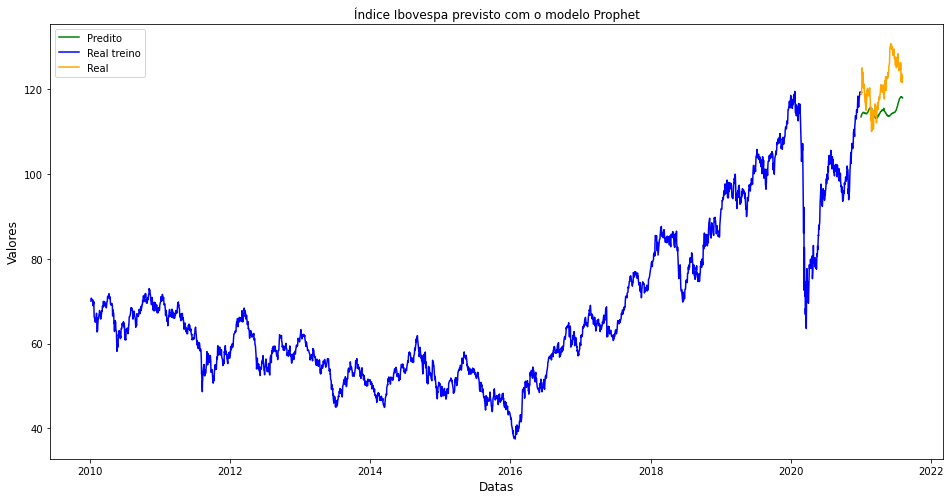

In [254]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Predito')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

# base de treino longa e previsão longa

5107
4537
570
          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


21:57:59 - cmdstanpy - INFO - Chain [1] start processing
21:58:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.52528622655929
total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:01 - cmdstanpy - INFO - Chain [1] start processing
21:58:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.58809116781642
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:07 - cmdstanpy - INFO - Chain [1] start processing
21:58:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.636062218258388
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:19 - cmdstanpy - INFO - Chain [1] start processing
21:58:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.709756149774368
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:24 - cmdstanpy - INFO - Chain [1] start processing
21:58:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.62699018914733
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:28 - cmdstanpy - INFO - Chain [1] start processing
21:58:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.642679851756704
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:36 - cmdstanpy - INFO - Chain [1] start processing
21:58:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.645910108721086
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:41 - cmdstanpy - INFO - Chain [1] start processing
21:58:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.692114424774864
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:52 - cmdstanpy - INFO - Chain [1] start processing
21:58:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.627681687213723
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:54 - cmdstanpy - INFO - Chain [1] start processing
21:58:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.014844463618264
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:58:58 - cmdstanpy - INFO - Chain [1] start processing
21:59:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.59157788805098
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:04 - cmdstanpy - INFO - Chain [1] start processing
21:59:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.78208162336687
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:10 - cmdstanpy - INFO - Chain [1] start processing
21:59:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.63730067709138
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:19 - cmdstanpy - INFO - Chain [1] start processing
21:59:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.575530589697877
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:25 - cmdstanpy - INFO - Chain [1] start processing
21:59:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.663712708973083
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.78643561724409
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:42 - cmdstanpy - INFO - Chain [1] start processing
21:59:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.581056241929126
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:45 - cmdstanpy - INFO - Chain [1] start processing
21:59:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.69282498159403
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:50 - cmdstanpy - INFO - Chain [1] start processing
21:59:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.587651805016005
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:53 - cmdstanpy - INFO - Chain [1] start processing
21:59:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.804073410163845
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
21:59:57 - cmdstanpy - INFO - Chain [1] start processing
22:00:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.60528530195574
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:00:04 - cmdstanpy - INFO - Chain [1] start processing
22:00:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.541675521936014
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:00:12 - cmdstanpy - INFO - Chain [1] start processing
22:00:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.60341359737124
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:00:15 - cmdstanpy - INFO - Chain [1] start processing
22:00:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.5602807638569
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:00:21 - cmdstanpy - INFO - Chain [1] start processing
22:00:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.282253029116294
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:00:26 - cmdstanpy - INFO - Chain [1] start processing
22:00:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.900076099763492
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:00:36 - cmdstanpy - INFO - Chain [1] start processing
22:00:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.213739114918198
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:00:39 - cmdstanpy - INFO - Chain [1] start processing
22:00:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.9188225225708
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:00:47 - cmdstanpy - INFO - Chain [1] start processing
22:00:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.181105204223314
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:00:52 - cmdstanpy - INFO - Chain [1] start processing
22:01:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.930246951790476
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:03 - cmdstanpy - INFO - Chain [1] start processing
22:01:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.042144213632838
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:05 - cmdstanpy - INFO - Chain [1] start processing
22:01:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.131876855448166
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:11 - cmdstanpy - INFO - Chain [1] start processing
22:01:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.185887457489287
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:15 - cmdstanpy - INFO - Chain [1] start processing
22:01:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.906716494277596
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:26 - cmdstanpy - INFO - Chain [1] start processing
22:01:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.172577300705722
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:30 - cmdstanpy - INFO - Chain [1] start processing
22:01:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.931909438172113
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:43 - cmdstanpy - INFO - Chain [1] start processing
22:01:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.011745855616574
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:45 - cmdstanpy - INFO - Chain [1] start processing
22:01:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.063223564904465
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:50 - cmdstanpy - INFO - Chain [1] start processing
22:01:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.066205151899947
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:01:54 - cmdstanpy - INFO - Chain [1] start processing
22:02:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.06054735522951
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:04 - cmdstanpy - INFO - Chain [1] start processing
22:02:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.17286585471496
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:08 - cmdstanpy - INFO - Chain [1] start processing
22:02:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.9536001268146
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:12 - cmdstanpy - INFO - Chain [1] start processing
22:02:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.15323007964312
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:14 - cmdstanpy - INFO - Chain [1] start processing
22:02:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.021996385539243
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:17 - cmdstanpy - INFO - Chain [1] start processing
22:02:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.111232825231745
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:20 - cmdstanpy - INFO - Chain [1] start processing
22:02:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.04839888467695
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:26 - cmdstanpy - INFO - Chain [1] start processing
22:02:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.155227342108756
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:29 - cmdstanpy - INFO - Chain [1] start processing
22:02:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.061088017312628
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:43 - cmdstanpy - INFO - Chain [1] start processing
22:02:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.404860424395903
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:47 - cmdstanpy - INFO - Chain [1] start processing
22:02:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.010248914393864
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:54 - cmdstanpy - INFO - Chain [1] start processing
22:02:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.470806898946764
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:02:56 - cmdstanpy - INFO - Chain [1] start processing
22:03:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.173766108593588
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:03:14 - cmdstanpy - INFO - Chain [1] start processing
22:03:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.40011647423557
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:03:17 - cmdstanpy - INFO - Chain [1] start processing
22:03:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.103068964261466
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:03:26 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.362733782047075
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:03:29 - cmdstanpy - INFO - Chain [1] start processing
22:03:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.119732712763081
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:01 - cmdstanpy - INFO - Chain [1] start processing
22:04:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.35625473262152
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:04 - cmdstanpy - INFO - Chain [1] start processing
22:04:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.506697243395864
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:07 - cmdstanpy - INFO - Chain [1] start processing
22:04:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.35028872590942
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:10 - cmdstanpy - INFO - Chain [1] start processing
22:04:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.203185207304303
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:20 - cmdstanpy - INFO - Chain [1] start processing
22:04:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.34812304872625
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:26 - cmdstanpy - INFO - Chain [1] start processing
22:04:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.55127338562293
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:34 - cmdstanpy - INFO - Chain [1] start processing
22:04:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.374927256598303
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:37 - cmdstanpy - INFO - Chain [1] start processing
22:04:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.232630549041978
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:44 - cmdstanpy - INFO - Chain [1] start processing
22:04:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.442201934576948
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:47 - cmdstanpy - INFO - Chain [1] start processing
22:04:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.0410892321597
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:04:58 - cmdstanpy - INFO - Chain [1] start processing
22:04:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.409530358438245
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:05:00 - cmdstanpy - INFO - Chain [1] start processing
22:05:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.12720693236092
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:05:11 - cmdstanpy - INFO - Chain [1] start processing
22:05:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.40469850024095
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:05:14 - cmdstanpy - INFO - Chain [1] start processing
22:05:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.095782408290741
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:05:32 - cmdstanpy - INFO - Chain [1] start processing
22:05:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.326970659194679
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:05:37 - cmdstanpy - INFO - Chain [1] start processing
22:05:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.588019847377666
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.567972565318577
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:05:45 - cmdstanpy - INFO - Chain [1] start processing
22:05:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.714223497472467
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:05:51 - cmdstanpy - INFO - Chain [1] start processing
22:05:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.529230737157057
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:06:00 - cmdstanpy - INFO - Chain [1] start processing
22:06:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.774408680158764
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:06:30 - cmdstanpy - INFO - Chain [1] start processing
22:06:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.612037048228526
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:06:40 - cmdstanpy - INFO - Chain [1] start processing
22:06:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.80337031605551
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:07:00 - cmdstanpy - INFO - Chain [1] start processing
22:07:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.532278075835478
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:07:05 - cmdstanpy - INFO - Chain [1] start processing
22:07:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.829170527955412
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:07:30 - cmdstanpy - INFO - Chain [1] start processing
22:07:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.526175380916904
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:07:36 - cmdstanpy - INFO - Chain [1] start processing
22:07:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.769669977599534
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:07:51 - cmdstanpy - INFO - Chain [1] start processing
22:07:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.550024207617874
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:07:54 - cmdstanpy - INFO - Chain [1] start processing
22:08:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.770025196536405
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:08:22 - cmdstanpy - INFO - Chain [1] start processing
22:08:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.597889420212567
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:08:27 - cmdstanpy - INFO - Chain [1] start processing
22:08:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.592829813370507
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:08:33 - cmdstanpy - INFO - Chain [1] start processing
22:08:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.535984216112748
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:08:41 - cmdstanpy - INFO - Chain [1] start processing
22:09:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.782680485254286
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:09:04 - cmdstanpy - INFO - Chain [1] start processing
22:09:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.631986274333723
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:09:12 - cmdstanpy - INFO - Chain [1] start processing
22:09:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.777373289312543
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:09:21 - cmdstanpy - INFO - Chain [1] start processing
22:09:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.534236286749607
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:09:25 - cmdstanpy - INFO - Chain [1] start processing
22:09:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.78502720630212
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:09:51 - cmdstanpy - INFO - Chain [1] start processing
22:09:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.542823343719665
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:09:58 - cmdstanpy - INFO - Chain [1] start processing
22:10:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.743747291969203
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:10:18 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.540478100096877
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:10:28 - cmdstanpy - INFO - Chain [1] start processing
22:10:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.699537720118784
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:10:45 - cmdstanpy - INFO - Chain [1] start processing
22:10:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.887816459143863
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:10:53 - cmdstanpy - INFO - Chain [1] start processing
22:11:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.415040189279647
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:11:05 - cmdstanpy - INFO - Chain [1] start processing
22:11:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.957826193470613
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:11:09 - cmdstanpy - INFO - Chain [1] start processing
22:11:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.4414539428559
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:11:24 - cmdstanpy - INFO - Chain [1] start processing
22:11:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.982917694943954
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:11:33 - cmdstanpy - INFO - Chain [1] start processing
22:11:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.451145075823593
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:11:55 - cmdstanpy - INFO - Chain [1] start processing
22:11:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.938264481614247
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:12:00 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.4644510966077
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:12:23 - cmdstanpy - INFO - Chain [1] start processing
22:12:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.90640207310904
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.415180444511773
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:12:41 - cmdstanpy - INFO - Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.933104625259556
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:12:48 - cmdstanpy - INFO - Chain [1] start processing
22:13:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.46398367132284
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:13:08 - cmdstanpy - INFO - Chain [1] start processing
22:13:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.940633245468653
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:13:19 - cmdstanpy - INFO - Chain [1] start processing
22:13:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.45441618442037
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:13:44 - cmdstanpy - INFO - Chain [1] start processing
22:13:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.95705649506687
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:13:50 - cmdstanpy - INFO - Chain [1] start processing
22:14:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.45865306091013
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.91689498917262
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.42393816018795
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:14:35 - cmdstanpy - INFO - Chain [1] start processing
22:14:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.986310872608996
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:14:39 - cmdstanpy - INFO - Chain [1] start processing
22:14:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.425542584623926
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:14:59 - cmdstanpy - INFO - Chain [1] start processing
22:15:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.951284097868115
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:15:08 - cmdstanpy - INFO - Chain [1] start processing
22:15:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.441360174580122
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:15:34 - cmdstanpy - INFO - Chain [1] start processing
22:15:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.98633681777208
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:15:46 - cmdstanpy - INFO - Chain [1] start processing
22:16:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.446862658871773
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:16:15 - cmdstanpy - INFO - Chain [1] start processing
22:16:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.33902295860652
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:16:19 - cmdstanpy - INFO - Chain [1] start processing
22:16:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.792384862539228
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:16:33 - cmdstanpy - INFO - Chain [1] start processing
22:16:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.350208332938724
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:16:38 - cmdstanpy - INFO - Chain [1] start processing
22:16:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.661874241516871
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:16:49 - cmdstanpy - INFO - Chain [1] start processing
22:16:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.353887525458594
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:16:59 - cmdstanpy - INFO - Chain [1] start processing
22:17:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.947355755393332
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:17:17 - cmdstanpy - INFO - Chain [1] start processing
22:17:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.318721802938143
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:17:23 - cmdstanpy - INFO - Chain [1] start processing
22:18:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.835036351149334
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:18:01 - cmdstanpy - INFO - Chain [1] start processing
22:18:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.34858400656924
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:18:05 - cmdstanpy - INFO - Chain [1] start processing
22:18:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.99753106030309
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:18:20 - cmdstanpy - INFO - Chain [1] start processing
22:18:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.35465569856909
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:18:29 - cmdstanpy - INFO - Chain [1] start processing
22:18:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.691782658903044
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:18:45 - cmdstanpy - INFO - Chain [1] start processing
22:18:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.300935857141868
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:18:52 - cmdstanpy - INFO - Chain [1] start processing
22:19:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.942975196853565
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:19:20 - cmdstanpy - INFO - Chain [1] start processing
22:19:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.287387563350661
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:19:31 - cmdstanpy - INFO - Chain [1] start processing
22:19:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.651206822845861
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:19:53 - cmdstanpy - INFO - Chain [1] start processing
22:19:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.305110597404182
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:19:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.767909232597258
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:20:07 - cmdstanpy - INFO - Chain [1] start processing
22:20:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.307808713170395
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:20:17 - cmdstanpy - INFO - Chain [1] start processing
22:20:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.980301874775995
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:20:36 - cmdstanpy - INFO - Chain [1] start processing
22:20:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.380540514221892
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:20:45 - cmdstanpy - INFO - Chain [1] start processing
22:21:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.976344623057656
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:21:14 - cmdstanpy - INFO - Chain [1] start processing
22:21:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.365475434257538
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:21:22 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.845458731383689
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:21:51 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.014794799962818
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:22:01 - cmdstanpy - INFO - Chain [1] start processing
22:22:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.89229395796827
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:22:08 - cmdstanpy - INFO - Chain [1] start processing
22:22:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.0356378562797
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:22:16 - cmdstanpy - INFO - Chain [1] start processing
22:22:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.895215284700463
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:22:34 - cmdstanpy - INFO - Chain [1] start processing
22:22:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.062032570382826
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:22:42 - cmdstanpy - INFO - Chain [1] start processing
22:22:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.974381211479454
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:22:57 - cmdstanpy - INFO - Chain [1] start processing
22:23:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.025867581908898
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:23:07 - cmdstanpy - INFO - Chain [1] start processing
22:23:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.85495100683382
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:23:23 - cmdstanpy - INFO - Chain [1] start processing
22:23:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.043512207172864
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:23:27 - cmdstanpy - INFO - Chain [1] start processing
22:23:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.946005030403143
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:23:39 - cmdstanpy - INFO - Chain [1] start processing
22:23:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.0312151222294
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:23:54 - cmdstanpy - INFO - Chain [1] start processing
22:24:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.8706251355621
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:24:03 - cmdstanpy - INFO - Chain [1] start processing
22:24:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.973798244857882
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:24:08 - cmdstanpy - INFO - Chain [1] start processing
22:24:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.81868388900623
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:24:17 - cmdstanpy - INFO - Chain [1] start processing
22:24:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.038625408640762
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:24:31 - cmdstanpy - INFO - Chain [1] start processing
22:24:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.902653753201612
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:24:42 - cmdstanpy - INFO - Chain [1] start processing
22:24:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.141391604108676
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:24:53 - cmdstanpy - INFO - Chain [1] start processing
22:24:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.848155183823053
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:25:00 - cmdstanpy - INFO - Chain [1] start processing
22:25:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.070879529088984
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.90670519785353
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:25:23 - cmdstanpy - INFO - Chain [1] start processing
22:25:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.042543752977014
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.989483322034452
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:25:54 - cmdstanpy - INFO - Chain [1] start processing
22:26:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.029055781234103
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:26:02 - cmdstanpy - INFO - Chain [1] start processing
22:26:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.95161918009393
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:26:15 - cmdstanpy - INFO - Chain [1] start processing
22:26:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.647580386889796
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:26:20 - cmdstanpy - INFO - Chain [1] start processing
22:26:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.342020122972464
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:26:29 - cmdstanpy - INFO - Chain [1] start processing
22:26:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.652769261154084
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:26:40 - cmdstanpy - INFO - Chain [1] start processing
22:26:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.316531695909816
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:26:51 - cmdstanpy - INFO - Chain [1] start processing
22:26:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.67400449824095
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.36186727866332
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:27:20 - cmdstanpy - INFO - Chain [1] start processing
22:27:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.700438268584033
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:27:26 - cmdstanpy - INFO - Chain [1] start processing
22:27:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.352229063772633
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.66973954762618
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:28:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.38248396192825
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:28:08 - cmdstanpy - INFO - Chain [1] start processing
22:28:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.687438187226867
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:28:13 - cmdstanpy - INFO - Chain [1] start processing
22:28:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.369148664849103
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:28:29 - cmdstanpy - INFO - Chain [1] start processing
22:28:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.652492526361822
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:28:36 - cmdstanpy - INFO - Chain [1] start processing
22:28:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.364882148816406
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:28:46 - cmdstanpy - INFO - Chain [1] start processing
22:28:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.59311257747351
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:29:00 - cmdstanpy - INFO - Chain [1] start processing
22:29:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.37224797065588
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:29:14 - cmdstanpy - INFO - Chain [1] start processing
22:29:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.658361587167736
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:29:23 - cmdstanpy - INFO - Chain [1] start processing
22:29:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.33049215282417
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:29:34 - cmdstanpy - INFO - Chain [1] start processing
22:29:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.639682760338818
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:29:40 - cmdstanpy - INFO - Chain [1] start processing
22:30:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.380255077295928
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:30:04 - cmdstanpy - INFO - Chain [1] start processing
22:30:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.691510744889722
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:30:11 - cmdstanpy - INFO - Chain [1] start processing
22:30:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.37006111004395
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:30:27 - cmdstanpy - INFO - Chain [1] start processing
22:30:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.699206213619014
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:30:34 - cmdstanpy - INFO - Chain [1] start processing
22:30:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.375830153708467
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:30:51 - cmdstanpy - INFO - Chain [1] start processing
22:30:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.281374501363445
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:31:01 - cmdstanpy - INFO - Chain [1] start processing
22:31:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.305177656724402
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:31:14 - cmdstanpy - INFO - Chain [1] start processing
22:31:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.293038698266246
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:31:24 - cmdstanpy - INFO - Chain [1] start processing
22:31:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.627836581550044
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:31:49 - cmdstanpy - INFO - Chain [1] start processing
22:32:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.297865281182078
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:32:01 - cmdstanpy - INFO - Chain [1] start processing
22:32:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.60279465658187
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:32:21 - cmdstanpy - INFO - Chain [1] start processing
22:32:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.275731504119431
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:32:29 - cmdstanpy - INFO - Chain [1] start processing
22:32:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.560768437345292
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:33:00 - cmdstanpy - INFO - Chain [1] start processing
22:33:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.25796181909919
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:33:04 - cmdstanpy - INFO - Chain [1] start processing
22:33:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.25670459333858
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:33:24 - cmdstanpy - INFO - Chain [1] start processing
22:33:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.28590142862973
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:33:32 - cmdstanpy - INFO - Chain [1] start processing
22:33:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.478093208867037
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:33:59 - cmdstanpy - INFO - Chain [1] start processing
22:34:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.305788205699864
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:34:08 - cmdstanpy - INFO - Chain [1] start processing
22:34:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.72483558232736
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:34:29 - cmdstanpy - INFO - Chain [1] start processing
22:34:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.309575250267049
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:34:45 - cmdstanpy - INFO - Chain [1] start processing
22:35:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.911675619796469
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:35:08 - cmdstanpy - INFO - Chain [1] start processing
22:35:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.254462176098412
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:35:24 - cmdstanpy - INFO - Chain [1] start processing
22:35:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.340214669449187
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:35:43 - cmdstanpy - INFO - Chain [1] start processing
22:36:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.361634507703426
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:36:03 - cmdstanpy - INFO - Chain [1] start processing
22:36:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.771262163572809
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:36:27 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.285552030091267
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:36:39 - cmdstanpy - INFO - Chain [1] start processing
22:37:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.539146556429023
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:37:01 - cmdstanpy - INFO - Chain [1] start processing
22:37:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.319229383197193
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:37:18 - cmdstanpy - INFO - Chain [1] start processing
22:37:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.860763252298955
total:  100.0
RMSE: 11.010248914393864
MAE: 9.325164322573194
MAPE: 0.0867593618428872
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_25800\2019663716.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
22:37:40 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing


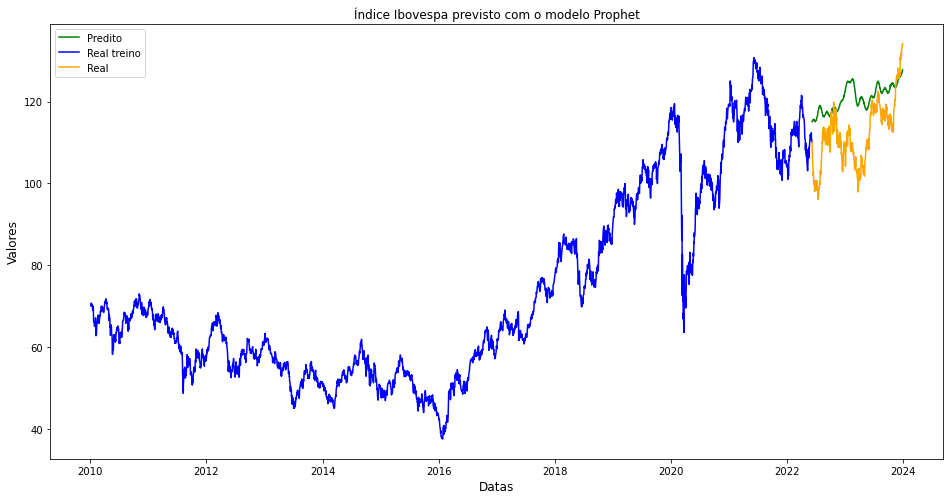

In [265]:
prophet_train, prophet_test = split(df_prophet, '2022-06-06')
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,10,20],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1
    
    import holidays

# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())


import random
import numpy as np
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(prophet_train)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = prophet_test
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)
    
    
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

print(f"Melhores parâmetros: changepoint_prior_scale :{parameters.loc[0, 'Parameters']['changepoint_prior_scale']}\nholidays_prior_scale: {parameters.loc[0, 'Parameters']['holidays_prior_scale']}\nn_changepoints: {parameters.loc[0, 'Parameters']['n_changepoints']}\nchangepoint_range:{parameters.loc[0, 'Parameters']['changepoint_range']}\nseasonality_mode: {parameters.loc[0, 'Parameters']['seasonality_mode']}")

print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])


predicao=train_forecast[['ds','yhat']]
Actual = prophet_test
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
RMSE

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Predito')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

5107
4167
940
          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


10:32:25 - cmdstanpy - INFO - Chain [1] start processing
10:32:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.295708555494173
total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:32:28 - cmdstanpy - INFO - Chain [1] start processing
10:32:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.546074823159334
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:32:32 - cmdstanpy - INFO - Chain [1] start processing
10:32:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.237400586702293
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:32:37 - cmdstanpy - INFO - Chain [1] start processing
10:32:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.607862374286434
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:32:49 - cmdstanpy - INFO - Chain [1] start processing
10:32:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.191318292427543
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:32:51 - cmdstanpy - INFO - Chain [1] start processing
10:32:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.55216018121157
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:32:57 - cmdstanpy - INFO - Chain [1] start processing
10:33:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.2470231841303
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:01 - cmdstanpy - INFO - Chain [1] start processing
10:33:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.4488330000479
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:12 - cmdstanpy - INFO - Chain [1] start processing
10:33:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.194076673550835
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:20 - cmdstanpy - INFO - Chain [1] start processing
10:33:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.600783986557808
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:24 - cmdstanpy - INFO - Chain [1] start processing
10:33:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.21354418139579
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:27 - cmdstanpy - INFO - Chain [1] start processing
10:33:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.647753690402897
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:31 - cmdstanpy - INFO - Chain [1] start processing
10:33:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.238273661783865
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:34 - cmdstanpy - INFO - Chain [1] start processing
10:33:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.630774048645097
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:40 - cmdstanpy - INFO - Chain [1] start processing
10:33:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.293351788778807
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:43 - cmdstanpy - INFO - Chain [1] start processing
10:33:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.39774523370944
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:52 - cmdstanpy - INFO - Chain [1] start processing
10:33:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.209318549853382
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:56 - cmdstanpy - INFO - Chain [1] start processing
10:33:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.57994230002607
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:33:59 - cmdstanpy - INFO - Chain [1] start processing
10:34:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.22498360518791
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:34:02 - cmdstanpy - INFO - Chain [1] start processing
10:34:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.549922407998544
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:34:05 - cmdstanpy - INFO - Chain [1] start processing
10:34:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.240033479591563
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:34:09 - cmdstanpy - INFO - Chain [1] start processing
10:34:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.657121221666138
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:34:21 - cmdstanpy - INFO - Chain [1] start processing
10:34:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.255054456746283
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:34:24 - cmdstanpy - INFO - Chain [1] start processing
10:34:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.66591861403458
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:34:31 - cmdstanpy - INFO - Chain [1] start processing
10:34:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.29775100861897
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:34:37 - cmdstanpy - INFO - Chain [1] start processing
10:34:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.75291160914111
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:34:48 - cmdstanpy - INFO - Chain [1] start processing
10:34:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.31710861230665
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:34:50 - cmdstanpy - INFO - Chain [1] start processing
10:35:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.724866977740422
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:35:01 - cmdstanpy - INFO - Chain [1] start processing
10:35:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.29227043611437
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:35:13 - cmdstanpy - INFO - Chain [1] start processing
10:35:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.813060231862945
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:35:26 - cmdstanpy - INFO - Chain [1] start processing
10:35:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.32647992464955
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:35:34 - cmdstanpy - INFO - Chain [1] start processing
10:35:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.808739652681098
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:35:48 - cmdstanpy - INFO - Chain [1] start processing
10:35:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.261839040215463
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:35:51 - cmdstanpy - INFO - Chain [1] start processing
10:36:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.699029000500648
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:36:11 - cmdstanpy - INFO - Chain [1] start processing
10:36:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.34498874010048
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.76642819078231
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:36:21 - cmdstanpy - INFO - Chain [1] start processing
10:36:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.328697777700697
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.80640218734043
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.305878194155934
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:36:50 - cmdstanpy - INFO - Chain [1] start processing
10:37:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.79070695318607
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:37:16 - cmdstanpy - INFO - Chain [1] start processing
10:37:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.30161450995302
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:37:19 - cmdstanpy - INFO - Chain [1] start processing
10:37:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.74564305687673
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:37:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.287184163259543
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:37:42 - cmdstanpy - INFO - Chain [1] start processing
10:37:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.77959485479517
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:37:54 - cmdstanpy - INFO - Chain [1] start processing
10:37:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.295918777661974
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:38:00 - cmdstanpy - INFO - Chain [1] start processing
10:38:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.747826331146005
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:38:10 - cmdstanpy - INFO - Chain [1] start processing
10:38:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.259519572272158
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:38:21 - cmdstanpy - INFO - Chain [1] start processing
10:38:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.76293732054549
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:38:33 - cmdstanpy - INFO - Chain [1] start processing
10:38:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.14262273241128
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:38:40 - cmdstanpy - INFO - Chain [1] start processing
10:38:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.57477285003356
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:38:54 - cmdstanpy - INFO - Chain [1] start processing
10:38:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.30026776970736
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:38:58 - cmdstanpy - INFO - Chain [1] start processing
10:39:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.730867327565583
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:39:12 - cmdstanpy - INFO - Chain [1] start processing
10:39:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.05408768308183
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:39:15 - cmdstanpy - INFO - Chain [1] start processing
10:39:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.201740656349427
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:39:28 - cmdstanpy - INFO - Chain [1] start processing
10:39:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.268527355148084
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:39:31 - cmdstanpy - INFO - Chain [1] start processing
10:39:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.227504175066167
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:39:52 - cmdstanpy - INFO - Chain [1] start processing
10:39:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.967261818232412
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:39:54 - cmdstanpy - INFO - Chain [1] start processing
10:40:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.815078005159755
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:40:03 - cmdstanpy - INFO - Chain [1] start processing
10:40:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.652101682504423
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:40:06 - cmdstanpy - INFO - Chain [1] start processing
10:40:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.521346189290302
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:40:12 - cmdstanpy - INFO - Chain [1] start processing
10:40:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.974065906714163
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:40:17 - cmdstanpy - INFO - Chain [1] start processing
10:40:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.221903266861686
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:40:32 - cmdstanpy - INFO - Chain [1] start processing
10:40:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.023845674883336
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:40:35 - cmdstanpy - INFO - Chain [1] start processing
10:40:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.932211495595535
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:40:54 - cmdstanpy - INFO - Chain [1] start processing
10:40:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.29147927128756
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:40:58 - cmdstanpy - INFO - Chain [1] start processing
10:41:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.424043992420831
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.214323573249906
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:41:19 - cmdstanpy - INFO - Chain [1] start processing
10:41:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.256268392385687
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:41:26 - cmdstanpy - INFO - Chain [1] start processing
10:41:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.98907158396362
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:41:32 - cmdstanpy - INFO - Chain [1] start processing
10:41:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.377524514715258
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:41:43 - cmdstanpy - INFO - Chain [1] start processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.13021187722593
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:41:46 - cmdstanpy - INFO - Chain [1] start processing
10:42:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.485059488919633
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:42:02 - cmdstanpy - INFO - Chain [1] start processing
10:42:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.17427154308137
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.64128052869616
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:42:16 - cmdstanpy - INFO - Chain [1] start processing
10:42:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.154523780849097
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:42:19 - cmdstanpy - INFO - Chain [1] start processing
10:42:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.792621924479217
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:42:35 - cmdstanpy - INFO - Chain [1] start processing
10:42:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.204063969046096
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:42:41 - cmdstanpy - INFO - Chain [1] start processing
10:42:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.441751400783243
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:42:49 - cmdstanpy - INFO - Chain [1] start processing
10:42:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.157363828140635
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:42:54 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.805370646008672
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.236552983747565
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.73422453109989
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:43:35 - cmdstanpy - INFO - Chain [1] start processing
10:43:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.188436469689012
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:43:38 - cmdstanpy - INFO - Chain [1] start processing
10:43:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.815119403453867
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:43:56 - cmdstanpy - INFO - Chain [1] start processing
10:43:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.21619601636049
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:44:00 - cmdstanpy - INFO - Chain [1] start processing
10:44:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.626582688210895
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:44:31 - cmdstanpy - INFO - Chain [1] start processing
10:44:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.154313476887413
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:44:42 - cmdstanpy - INFO - Chain [1] start processing
10:45:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.50860028300853
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:45:05 - cmdstanpy - INFO - Chain [1] start processing
10:45:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.129916350860963
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:45:14 - cmdstanpy - INFO - Chain [1] start processing
10:45:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.772321577118326
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:45:54 - cmdstanpy - INFO - Chain [1] start processing
10:46:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.152729225683917


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


10:46:16 - cmdstanpy - INFO - Chain [1] start processing
10:47:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.455884356030243
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:47:33 - cmdstanpy - INFO - Chain [1] start processing
10:47:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.204075870818155
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:47:39 - cmdstanpy - INFO - Chain [1] start processing
10:48:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.68717480211564
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:48:22 - cmdstanpy - INFO - Chain [1] start processing
10:48:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.197629306704318
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:48:38 - cmdstanpy - INFO - Chain [1] start processing
10:49:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.639838045487362
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:49:11 - cmdstanpy - INFO - Chain [1] start processing
10:49:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.825435215847598
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:49:21 - cmdstanpy - INFO - Chain [1] start processing
10:49:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.947133538210565
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:49:31 - cmdstanpy - INFO - Chain [1] start processing
10:49:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.85948490864538
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:49:35 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.963042070327415
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.868392211882913
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:50:09 - cmdstanpy - INFO - Chain [1] start processing
10:50:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.917649964250945
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:50:37 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.9219750031691
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.312339511068668
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.93391494720616
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.96775910987889
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:51:45 - cmdstanpy - INFO - Chain [1] start processing
10:51:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.87288308789211
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:51:58 - cmdstanpy - INFO - Chain [1] start processing
10:52:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.948927405617837
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:52:29 - cmdstanpy - INFO - Chain [1] start processing
10:52:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.89730536076915
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:52:39 - cmdstanpy - INFO - Chain [1] start processing
10:53:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.994455708619615
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:53:13 - cmdstanpy - INFO - Chain [1] start processing
10:53:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.9072209274853
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:53:23 - cmdstanpy - INFO - Chain [1] start processing
10:53:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.97417274853603
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:53:41 - cmdstanpy - INFO - Chain [1] start processing
10:53:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.92559518251627
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:53:50 - cmdstanpy - INFO - Chain [1] start processing
10:54:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.976787056353952
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:54:11 - cmdstanpy - INFO - Chain [1] start processing
10:54:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.873116876760054
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:54:17 - cmdstanpy - INFO - Chain [1] start processing
10:54:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.97647810227657
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:54:50 - cmdstanpy - INFO - Chain [1] start processing
10:54:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.866062697355677
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:55:00 - cmdstanpy - INFO - Chain [1] start processing
10:55:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.99180032683871
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:55:22 - cmdstanpy - INFO - Chain [1] start processing
10:55:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.832763990055124
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:55:37 - cmdstanpy - INFO - Chain [1] start processing
10:56:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.993461563858286
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:56:12 - cmdstanpy - INFO - Chain [1] start processing
10:56:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.982991904062565
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:56:16 - cmdstanpy - INFO - Chain [1] start processing
10:56:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.770229873463173
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:56:28 - cmdstanpy - INFO - Chain [1] start processing
10:56:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.03828529585361
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:56:37 - cmdstanpy - INFO - Chain [1] start processing
10:57:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.679325318342704
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:57:03 - cmdstanpy - INFO - Chain [1] start processing
10:57:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.114504863914604
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:57:09 - cmdstanpy - INFO - Chain [1] start processing
10:57:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.910181239751145
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:57:38 - cmdstanpy - INFO - Chain [1] start processing
10:57:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.048266153162487
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:57:47 - cmdstanpy - INFO - Chain [1] start processing
10:58:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.594124144242537
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:58:20 - cmdstanpy - INFO - Chain [1] start processing
10:58:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.0027374568074
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:58:25 - cmdstanpy - INFO - Chain [1] start processing
10:58:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.778123917788239
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:58:49 - cmdstanpy - INFO - Chain [1] start processing
10:58:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.119957302822108
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:58:54 - cmdstanpy - INFO - Chain [1] start processing
10:59:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.776163635354596
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:59:27 - cmdstanpy - INFO - Chain [1] start processing
10:59:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.159864289417524
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
10:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:00:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96465991472579
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:00:08 - cmdstanpy - INFO - Chain [1] start processing
11:00:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.04588164981466
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:00:22 - cmdstanpy - INFO - Chain [1] start processing
11:00:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.705185806534441
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:00:44 - cmdstanpy - INFO - Chain [1] start processing
11:00:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.108032832592443
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:00:47 - cmdstanpy - INFO - Chain [1] start processing
11:00:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.771127442390299
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:00:59 - cmdstanpy - INFO - Chain [1] start processing
11:01:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.128570284105784
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:01:06 - cmdstanpy - INFO - Chain [1] start processing
11:01:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.740499519280743
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:01:27 - cmdstanpy - INFO - Chain [1] start processing
11:01:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.173512408450076
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:01:32 - cmdstanpy - INFO - Chain [1] start processing
11:02:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.985818591147007
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


11:02:19 - cmdstanpy - INFO - Chain [1] start processing
11:02:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.158094092335787
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:02:34 - cmdstanpy - INFO - Chain [1] start processing
11:02:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.911940896972414
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:02:57 - cmdstanpy - INFO - Chain [1] start processing
11:03:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.48146361148852
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:03:01 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.912429336253727
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:03:20 - cmdstanpy - INFO - Chain [1] start processing
11:03:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.50008892325096
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:03:30 - cmdstanpy - INFO - Chain [1] start processing
11:03:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.84840845081596
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:03:38 - cmdstanpy - INFO - Chain [1] start processing
11:03:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.524632206019184
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.974240132145127
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:03:59 - cmdstanpy - INFO - Chain [1] start processing
11:04:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.539438438126385
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.81639798665077
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.520423683275776
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:04:38 - cmdstanpy - INFO - Chain [1] start processing
11:04:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.835968226102352
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:04:56 - cmdstanpy - INFO - Chain [1] start processing
11:05:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.484371875090112
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:05:04 - cmdstanpy - INFO - Chain [1] start processing
11:05:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.716623548782337
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:05:30 - cmdstanpy - INFO - Chain [1] start processing
11:05:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.50755388774953
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:06:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.86305100279722
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:06:18 - cmdstanpy - INFO - Chain [1] start processing
11:06:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.487568939740772
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:06:26 - cmdstanpy - INFO - Chain [1] start processing
11:06:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.819783289587935
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:06:49 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.506202362150155
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:06:52 - cmdstanpy - INFO - Chain [1] start processing
11:07:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.77377797273856
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:07:03 - cmdstanpy - INFO - Chain [1] start processing
11:07:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.53467139825103
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:07:17 - cmdstanpy - INFO - Chain [1] start processing
11:07:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.880994003245082
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:07:30 - cmdstanpy - INFO - Chain [1] start processing
11:07:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.51267768398923
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:07:40 - cmdstanpy - INFO - Chain [1] start processing
11:07:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.840629764097383
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:08:01 - cmdstanpy - INFO - Chain [1] start processing
11:08:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.447524586772857
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:08:07 - cmdstanpy - INFO - Chain [1] start processing
11:08:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.446711227237989
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:08:28 - cmdstanpy - INFO - Chain [1] start processing
11:08:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.49747215405979
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:08:39 - cmdstanpy - INFO - Chain [1] start processing
11:08:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.973821159490043
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:08:58 - cmdstanpy - INFO - Chain [1] start processing
11:09:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.518067928504
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:09:06 - cmdstanpy - INFO - Chain [1] start processing
11:09:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.034484231870806
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:09:31 - cmdstanpy - INFO - Chain [1] start processing
11:09:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.49610155184994
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:09:42 - cmdstanpy - INFO - Chain [1] start processing
11:10:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.032125608225908
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:10:14 - cmdstanpy - INFO - Chain [1] start processing
11:10:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.51247567747116
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:10:24 - cmdstanpy - INFO - Chain [1] start processing
11:10:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.01927706691885
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:10:45 - cmdstanpy - INFO - Chain [1] start processing
11:10:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.477152567824707
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:10:51 - cmdstanpy - INFO - Chain [1] start processing
11:10:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.051119450220366
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:11:02 - cmdstanpy - INFO - Chain [1] start processing
11:11:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.51728923714565
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:11:23 - cmdstanpy - INFO - Chain [1] start processing
11:11:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.210078439262976
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:11:38 - cmdstanpy - INFO - Chain [1] start processing
11:11:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.501345341859373
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:11:53 - cmdstanpy - INFO - Chain [1] start processing
11:12:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.375494011824145
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:12:05 - cmdstanpy - INFO - Chain [1] start processing
11:12:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.50342613852677
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:12:18 - cmdstanpy - INFO - Chain [1] start processing
11:12:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.084719410050017
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:12:45 - cmdstanpy - INFO - Chain [1] start processing
11:12:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.489180986110558
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:12:54 - cmdstanpy - INFO - Chain [1] start processing
11:13:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.006908065255832
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:13:09 - cmdstanpy - INFO - Chain [1] start processing
11:13:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.509154302096814
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:13:17 - cmdstanpy - INFO - Chain [1] start processing
11:13:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.050823134410003
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:13:41 - cmdstanpy - INFO - Chain [1] start processing
11:13:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.496587977704124
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:13:47 - cmdstanpy - INFO - Chain [1] start processing
11:14:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.038925374083718
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:14:17 - cmdstanpy - INFO - Chain [1] start processing
11:14:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.52771101055604
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:14:25 - cmdstanpy - INFO - Chain [1] start processing
11:14:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.00680038785288
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:14:54 - cmdstanpy - INFO - Chain [1] start processing
11:15:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.169079376591991
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:15:03 - cmdstanpy - INFO - Chain [1] start processing
11:15:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.763721132373357
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:15:23 - cmdstanpy - INFO - Chain [1] start processing
11:15:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.683328419791124
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:15:30 - cmdstanpy - INFO - Chain [1] start processing
11:15:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.57823732984862
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:15:58 - cmdstanpy - INFO - Chain [1] start processing
11:16:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.561091152704648
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:16:12 - cmdstanpy - INFO - Chain [1] start processing
11:16:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.62756109225296
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:16:37 - cmdstanpy - INFO - Chain [1] start processing
11:16:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.671493573600324
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:16:54 - cmdstanpy - INFO - Chain [1] start processing
11:17:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.93353756256601
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:17:19 - cmdstanpy - INFO - Chain [1] start processing
11:17:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.628854465596778
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:17:32 - cmdstanpy - INFO - Chain [1] start processing
11:17:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.693381575249965
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:17:48 - cmdstanpy - INFO - Chain [1] start processing
11:17:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.427700257542876
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:17:58 - cmdstanpy - INFO - Chain [1] start processing
11:18:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.472787301986013
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:18:28 - cmdstanpy - INFO - Chain [1] start processing
11:18:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.50932408654853
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:18:37 - cmdstanpy - INFO - Chain [1] start processing
11:19:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.14979548425771
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:19:09 - cmdstanpy - INFO - Chain [1] start processing
11:19:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.583642584366249
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:19:19 - cmdstanpy - INFO - Chain [1] start processing
11:19:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.701448917322583
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:19:49 - cmdstanpy - INFO - Chain [1] start processing
11:19:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.656454614262497
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:19:55 - cmdstanpy - INFO - Chain [1] start processing
11:20:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.783190938298377
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:20:22 - cmdstanpy - INFO - Chain [1] start processing
11:20:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.67907648139892
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:20:29 - cmdstanpy - INFO - Chain [1] start processing
11:20:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.467477834957574
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:20:54 - cmdstanpy - INFO - Chain [1] start processing
11:21:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.57601041992384
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:21:07 - cmdstanpy - INFO - Chain [1] start processing
11:21:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.514821741934636
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:21:34 - cmdstanpy - INFO - Chain [1] start processing
11:21:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.642137476456933
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
11:21:42 - cmdstanpy - INFO - Chain [1] start processing
11:22:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.036818490758282
total:  100.0
Melhores parâmetros: changepoint_prior_scale :0.08
holidays_prior_scale: 20
n_changepoints: 75
changepoint_range:0.8
seasonality_mode: multiplicative
RMSE: 13.467477834957574
MAE: 11.509547859074395
MAPE: 0.10387291221597325
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_12516\461534744.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


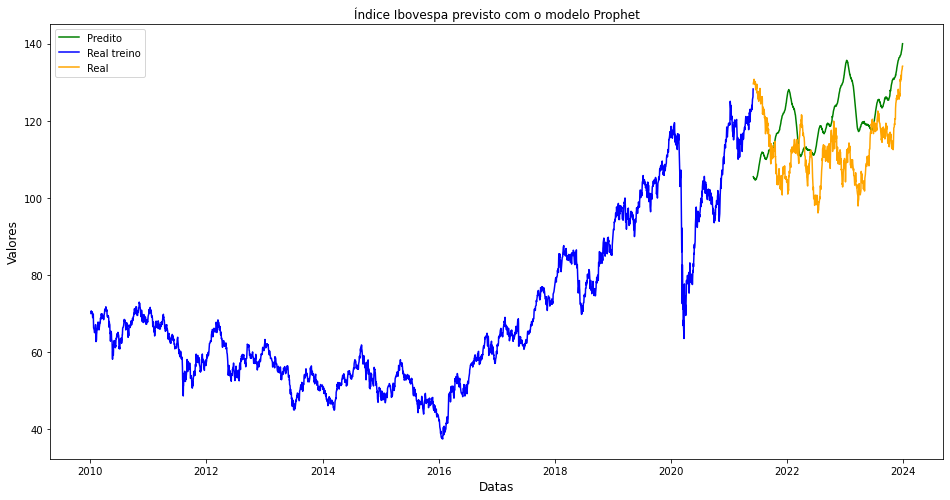

In [15]:
prophet_train, prophet_test = split(df_prophet, '2021-06-01')
prophet_test = prophet_test.iloc[:int(len(prophet_test) * 1)]
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,10,20],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1
    
    import holidays

# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())


import random
import numpy as np
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(prophet_train)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = prophet_test
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)
    
    
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

print(f"Melhores parâmetros: changepoint_prior_scale :{parameters.loc[0, 'Parameters']['changepoint_prior_scale']}\nholidays_prior_scale: {parameters.loc[0, 'Parameters']['holidays_prior_scale']}\nn_changepoints: {parameters.loc[0, 'Parameters']['n_changepoints']}\nchangepoint_range:{parameters.loc[0, 'Parameters']['changepoint_range']}\nseasonality_mode: {parameters.loc[0, 'Parameters']['seasonality_mode']}")

print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])


predicao=train_forecast[['ds','yhat']]
Actual = prophet_test
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
RMSE

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Predito')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

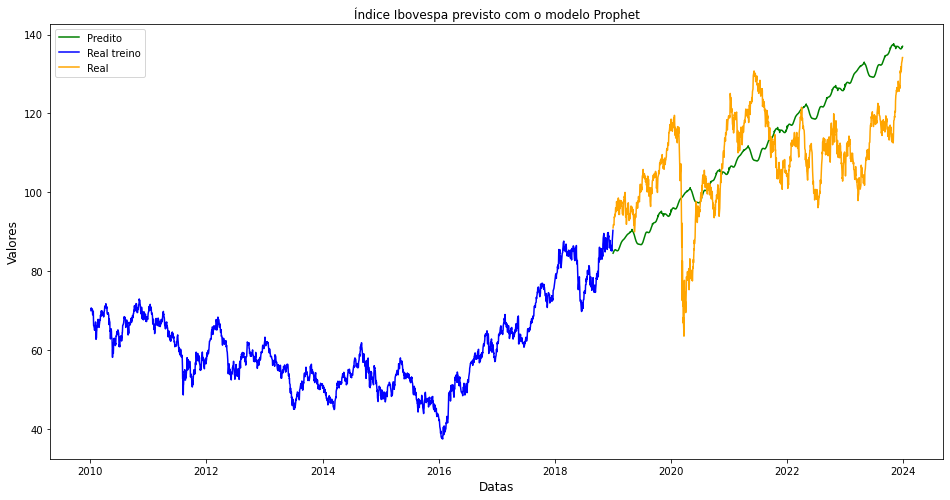

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Predito')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

5107
4197
910


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


A melhor configuração para essa série temporal é:[(0, 0, 1), (1, 0, 0, 12), 'ct']
rmse:7.81002551693061
mae:6.324229597297212
mape:0.05540165689756505


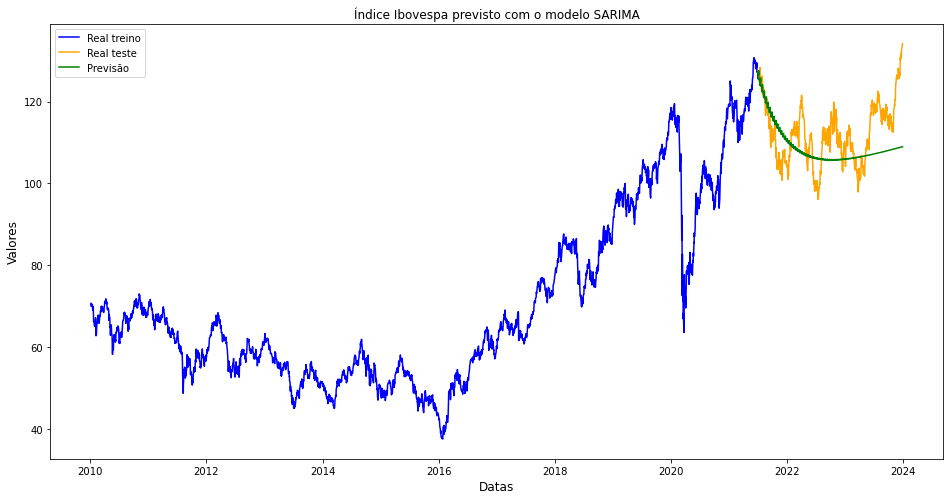

In [24]:
arima_train, arima_test = split(df_arima, '2021-07-01')

rmse,mae,mape,model, grid_search_melhor_conf, = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}\nrmse:{rmse}\nmae:{mae}\nmape:{mape}")

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = model.get_forecast(steps=len(arima_test))
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsão')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo SARIMA')

plt.legend()
plt.show()